In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append(r"/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import os
from os.path import join
import torch as th
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from circuit_toolkit.plot_utils import show_imgrid
from circuit_toolkit.layer_hook_utils import featureFetcher
from circuit_toolkit.dataset_utils import ImagePathDataset, DataLoader
from circuit_toolkit.plot_utils import saveallforms
from core.data_utils import load_neural_data, load_from_hdf5
from core.model_load_utils import load_model_transform
from neural_regress.regress_lib import record_features, perform_regression_sweeplayer, perform_regression_sweeplayer_RidgeCV
from neural_regress.regress_eval_lib import format_result_df, plot_result_df_per_layer, construct_result_df_masked, \
    compute_pred_dict_D2_per_unit

/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/GAN_invert_utils.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [15]:
def format_result_df(result_df):
    # format the result_df to be a dataframe with layer, dimred, regressor, train_score, test_score, parse the key index as layer_dimred, regressor , if it has column unnamed then rename it to layer_dimred, regressor
    """ if index is a multi-index, parse it as layer_dimred, regressor , if it has column unnamed then rename it to layer_dimred, regressor
    The latter case if possible when the frame is loaded from a csv file. 
    """
    if isinstance(result_df.index, pd.MultiIndex):
        result_df_formatted = result_df.reset_index()
        result_df_formatted.rename(columns={"level_0": "layer_dimred", "level_1": "regressor", }, inplace=True)
    else:
        result_df_formatted = result_df
        result_df_formatted.rename(columns={"Unnamed: 0": "layer_dimred", "Unnamed: 1": "regressor", }, inplace=True)
    result_df_formatted["layer"] = result_df_formatted["layer_dimred"].apply(lambda x: x.split("_")[0])
    result_df_formatted["dimred"] = result_df_formatted["layer_dimred"].apply(lambda x: x.split("_")[-1])
    return result_df_formatted

In [3]:
device = "cuda" if th.cuda.is_available() else "cpu"
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
data_path = join(dataroot, "nsd_shared1000_6monkeys_2024.h5")
stimroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/Stimuli/shared1000"
# Load data
data = load_from_hdf5(data_path)
print("subjects:", list(data.keys()))

subjects: ['baby1_20240329-20240325', 'baby1_240329-240325', 'baby5_240819-240822', 'paul_20240713-20240710', 'paul_240713-240710', 'red_20240713-20240710']


In [171]:
for subject_id in ['paul_240713-240710', 
                   'paul_20240713-20240710', 
                   'red_20240713-20240710',
                   'baby1_20240329-20240325', 
                   'baby1_240329-240325', 
                   'baby5_240819-240822', ]: 
    data_dict = load_neural_data(data_path, subject_id, stimroot)
    image_fps = data_dict['image_fps']
    resp_mat = data_dict['resp_mat']
    reliability = data_dict['reliability']
    ncsnr = data_dict['ncsnr']
    brain_area = [x.decode('utf-8') for x in data_dict['brain_area']]
    print(subject_id, "unit count:", len(reliability), "brain area:", np.unique(brain_area))

paul_240713-240710 unit count: 383 brain area: ['l_IT']
paul_20240713-20240710 unit count: 64 brain area: ['l_cIT']
red_20240713-20240710 unit count: 64 brain area: ['l_aIT']
baby1_20240329-20240325 unit count: 64 brain area: ['r_aIT']
baby1_240329-240325 unit count: 383 brain area: ['l_aIT']
baby5_240819-240822 unit count: 383 brain area: ['STS']


In [21]:
thresh = 0.0
synopsis_df = []
subject_id = 'paul_240713-240710'
for subject_id in ['paul_240713-240710', 
                   'paul_20240713-20240710', 
                   'red_20240713-20240710',
                   'baby1_20240329-20240325', 
                   'baby1_240329-240325', 
                   'baby5_240819-240822', ]: 
    data_dict = load_neural_data(data_path, subject_id, stimroot)
    image_fps = data_dict['image_fps']
    resp_mat = data_dict['resp_mat']
    reliability = data_dict['reliability']
    ncsnr = data_dict['ncsnr']
    figdir = join(dataroot, subject_id, "model_outputs")
    os.makedirs(figdir, exist_ok=True)
    for modelname in ["resnet50_clip", "resnet50_dino", "resnet50", "resnet50_robust", ]: # 
        pred_D2_dict = pkl.load(open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "rb"))
        result_df_lyrswp = pd.read_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
        result_df_formatted = format_result_df(result_df_lyrswp)
        channel_count = (reliability > thresh).sum()
        result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                        pred_D2_dict['D2_per_unit_test_dict'], 
                                                        mask=reliability > thresh)
        result_df_formatted = format_result_df(result_df_masked)
        result_df_formatted["modelname"] = modelname
        result_df_formatted["subject_id"] = subject_id
        synopsis_df.append(result_df_formatted)
        
synopsis_df = pd.concat(synopsis_df)
# synopsis_df.to_csv(join(dataroot, "neural_regression_layersweep_synopsis.csv"), index=False)

In [22]:
result_df_lyrswp

layer_dimred regressor  \
0   .layer1.Bottleneck0_pca1000   RidgeCV   
1       .layer1.Bottleneck0_srp   RidgeCV   
2   .layer1.Bottleneck0_srp1000   RidgeCV   
3   .layer1.Bottleneck1_pca1000   RidgeCV   
4       .layer1.Bottleneck1_srp   RidgeCV   
5   .layer1.Bottleneck1_srp1000   RidgeCV   
6   .layer1.Bottleneck2_pca1000   RidgeCV   
7       .layer1.Bottleneck2_srp   RidgeCV   
8   .layer1.Bottleneck2_srp1000   RidgeCV   
9   .layer2.Bottleneck0_pca1000   RidgeCV   
10      .layer2.Bottleneck0_srp   RidgeCV   
11  .layer2.Bottleneck0_srp1000   RidgeCV   
12  .layer2.Bottleneck1_pca1000   RidgeCV   
13      .layer2.Bottleneck1_srp   RidgeCV   
14  .layer2.Bottleneck1_srp1000   RidgeCV   
15  .layer2.Bottleneck2_pca1000   RidgeCV   
16      .layer2.Bottleneck2_srp   RidgeCV   
17  .layer2.Bottleneck2_srp1000   RidgeCV   
18  .layer2.Bottleneck3_pca1000   RidgeCV   
19      .layer2.Bottleneck3_srp   RidgeCV   
20  .layer2.Bottleneck3_srp1000   RidgeCV   
21  .layer3.Bottleneck0_pca1000   RidgeCV   
22      .layer3.Bottleneck0_srp   RidgeCV   
23  .layer3.Bottleneck0_srp1000   RidgeCV   
24  .layer3.Bottleneck1_pca1000   RidgeCV   
25      .layer3.Bottleneck1_srp   RidgeCV   
26  .layer3.Bottleneck1_srp1000   RidgeCV   
27  .layer3.Bottleneck2_pca1000   RidgeCV   
28      .layer3.Bottleneck2_srp   RidgeCV   
29  .layer3.Bottleneck2_srp1000   RidgeCV   
30  .layer3.Bottleneck3_pca1000   RidgeCV   
31      .layer3.Bottleneck3_srp   RidgeCV   
32  .layer3.Bottleneck3_srp1000   RidgeCV   
33  .layer3.Bottleneck4_pca1000   RidgeCV   
34      .layer3.Bottleneck4_srp   RidgeCV   
35  .layer3.Bottleneck4_srp1000   RidgeCV   
36  .layer3.Bottleneck5_pca1000   RidgeCV   
37      .layer3.Bottleneck5_srp   RidgeCV   
38  .layer3.Bottleneck5_srp1000   RidgeCV   
39  .layer4.Bottleneck0_pca1000   RidgeCV   
40      .layer4.Bottleneck0_srp   RidgeCV   
41  .layer4.Bottleneck0_srp1000   RidgeCV   
42  .layer4.Bottleneck1_pca1000   RidgeCV   
43      .layer4.Bottleneck1_srp   RidgeCV   
44  .layer4.Bottleneck1_srp1000   RidgeCV   
45  .layer4.Bottleneck2_pca1000   RidgeCV   
46      .layer4.Bottleneck2_srp   RidgeCV   
47  .layer4.Bottleneck2_srp1000   RidgeCV   

                                                alpha  train_score  \
0   [1.e+09 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.029535   
1   [1.e+09 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.028603   
2   [1.e+09 1.e+06 1.e+09 1.e+09 1.e+05 1.e+06 1.e...     0.021712   
3   [1.e+09 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.041848   
4   [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.038571   
5   [1.e+09 1.e+06 1.e+09 1.e+09 1.e+06 1.e+06 1.e...     0.025991   
6   [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.045208   
7   [1.e+06 1.e+06 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.042437   
8   [1.e+09 1.e+07 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.029007   
9   [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.035166   
10  [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.037311   
11  [1.e+09 1.e+06 1.e+05 1.e+09 1.e+05 1.e+06 1.e...     0.027249   
12  [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.045029   
13  [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.045324   
14  [1.e+09 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.030025   
15  [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.054354   
16  [1.e+06 1.e+06 1.e+07 1.e+09 1.e+04 1.e+06 1.e...     0.050577   
17  [1.e+06 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.030882   
18  [1.e+09 1.e+06 1.e+09 1.e+09 1.e+05 1.e+05 1.e...     0.061875   
19  [1.e+09 1.e+06 1.e+09 1.e+09 1.e+05 1.e+06 1.e...     0.057645   
20  [1.e+09 1.e+09 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.042784   
21  [1.e+09 1.e+06 1.e+09 1.e+09 1.e+04 1.e+05 1.e...     0.043832   
22  [1.e+09 1.e+06 1.e+09 1.e+09 1.e+05 1.e+05 1.e...     0.043862   
23  [1.e+05 1.e+09 1.e+09 1.e+09 1.e+05 1.e+05 1.e...     0.031691   
24  [1.e+06 1.e+06 1.e+09 1.e+09 1.e+04 1.e+05 1.e...     0.046

In [23]:
synopsis_df

layer_dimred regressor  train_score  test_score  \
0   .layer1.Bottleneck0_pca1000   RidgeCV     0.448628    0.048132   
1       .layer1.Bottleneck0_srp   RidgeCV     0.397842    0.043358   
2   .layer1.Bottleneck0_srp1000   RidgeCV     0.219585    0.016433   
3   .layer1.Bottleneck1_pca1000   RidgeCV     0.502655    0.051577   
4       .layer1.Bottleneck1_srp   RidgeCV     0.387181    0.038707   
..                          ...       ...          ...         ...   
43      .layer4.Bottleneck1_srp   RidgeCV     0.126224    0.029417   
44  .layer4.Bottleneck1_srp1000   RidgeCV     0.108371    0.025734   
45  .layer4.Bottleneck2_pca1000   RidgeCV     0.136427    0.032460   
46      .layer4.Bottleneck2_srp   RidgeCV     0.140624    0.030912   
47  .layer4.Bottleneck2_srp1000   RidgeCV     0.114563    0.027084   

                  layer   dimred        modelname           subject_id  
0   .layer1.Bottleneck0  pca1000    resnet50_clip   paul_240713-240710  
1   .layer1.Bottleneck0      srp    resnet50_clip   paul_240713-240710  
2   .layer1.Bottleneck0  srp1000    resnet50_clip   paul_240713-240710  
3   .layer1.Bottleneck1  pca1000    resnet50_clip   paul_240713-240710  
4   .layer1.Bottleneck1      srp    resnet50_clip   paul_240713-240710  
..                  ...      ...              ...                  ...  
43  .layer4.Bottleneck1      srp  resnet50_robust  baby5_240819-240822  
44  .layer4.Bottleneck1  srp1000  resnet50_robust  baby5_240819-240822  
45  .layer4.Bottleneck2  pca1000  resnet50_robust  baby5_240819-240822  
46  .layer4.Bottleneck2      srp  resnet50_robust  baby5_240819-240822  
47  .layer4.Bottleneck2  srp1000  resnet50_robust  baby5_240819-240822  

[1152 rows x 8 columns]

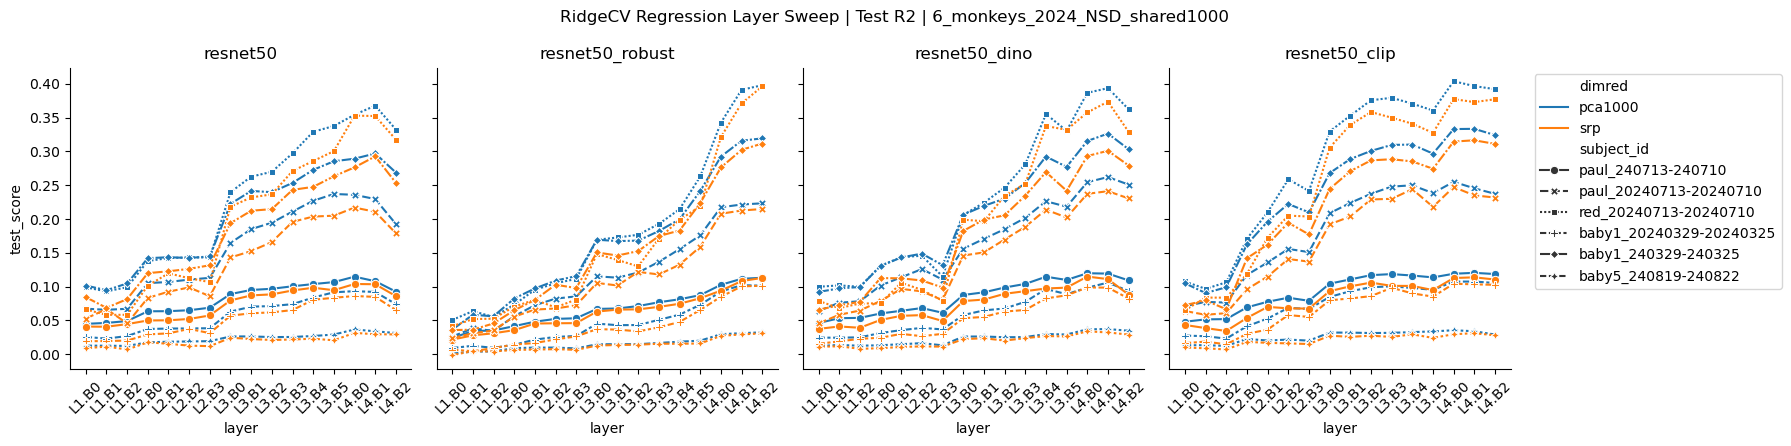

In [37]:
shorten_func = lambda x: x.replace("Bottleneck", "B").replace(".layer", "L")
fig, axes = plt.subplots(1, 4, figsize=(18, 4.5), sharey=True)
axes = axes.flatten()
for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
    subdf = synopsis_df.query("modelname == @modelname")
    sns.lineplot(data=subdf, x="layer", y="test_score", 
                 hue="dimred", style="subject_id", ax=axes[i],
                 hue_order=["pca1000", "srp"],
                 legend=False if i < 3 else True, markers=True)
    axes[i].set_title(modelname)
    axes[i].tick_params(axis='x', rotation=45)
    # make the xticks be the layer names, simpler and more readable
    xticklabels = axes[i].get_xticklabels()
    xticklabels = [shorten_func(label.get_text()) for label in xticklabels]
    axes[i].set_xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    # axes[i].set_title("Training R2")

if axes[-1].get_legend():
    # Move legend outside the last subplot
    axes[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle("RidgeCV Regression Layer Sweep | Test R2 | 6_monkeys_2024_NSD_shared1000")
plt.tight_layout()

In [13]:
format_result_df(result_df_lyrswp)

layer_dimred regressor  \
0   .layer1.Bottleneck0_pca1000   RidgeCV   
1       .layer1.Bottleneck0_srp   RidgeCV   
2   .layer1.Bottleneck0_srp1000   RidgeCV   
3   .layer1.Bottleneck1_pca1000   RidgeCV   
4       .layer1.Bottleneck1_srp   RidgeCV   
5   .layer1.Bottleneck1_srp1000   RidgeCV   
6   .layer1.Bottleneck2_pca1000   RidgeCV   
7       .layer1.Bottleneck2_srp   RidgeCV   
8   .layer1.Bottleneck2_srp1000   RidgeCV   
9   .layer2.Bottleneck0_pca1000   RidgeCV   
10      .layer2.Bottleneck0_srp   RidgeCV   
11  .layer2.Bottleneck0_srp1000   RidgeCV   
12  .layer2.Bottleneck1_pca1000   RidgeCV   
13      .layer2.Bottleneck1_srp   RidgeCV   
14  .layer2.Bottleneck1_srp1000   RidgeCV   
15  .layer2.Bottleneck2_pca1000   RidgeCV   
16      .layer2.Bottleneck2_srp   RidgeCV   
17  .layer2.Bottleneck2_srp1000   RidgeCV   
18  .layer2.Bottleneck3_pca1000   RidgeCV   
19      .layer2.Bottleneck3_srp   RidgeCV   
20  .layer2.Bottleneck3_srp1000   RidgeCV   
21  .layer3.Bottleneck0_pca1000   RidgeCV   
22      .layer3.Bottleneck0_srp   RidgeCV   
23  .layer3.Bottleneck0_srp1000   RidgeCV   
24  .layer3.Bottleneck1_pca1000   RidgeCV   
25      .layer3.Bottleneck1_srp   RidgeCV   
26  .layer3.Bottleneck1_srp1000   RidgeCV   
27  .layer3.Bottleneck2_pca1000   RidgeCV   
28      .layer3.Bottleneck2_srp   RidgeCV   
29  .layer3.Bottleneck2_srp1000   RidgeCV   
30  .layer3.Bottleneck3_pca1000   RidgeCV   
31      .layer3.Bottleneck3_srp   RidgeCV   
32  .layer3.Bottleneck3_srp1000   RidgeCV   
33  .layer3.Bottleneck4_pca1000   RidgeCV   
34      .layer3.Bottleneck4_srp   RidgeCV   
35  .layer3.Bottleneck4_srp1000   RidgeCV   
36  .layer3.Bottleneck5_pca1000   RidgeCV   
37      .layer3.Bottleneck5_srp   RidgeCV   
38  .layer3.Bottleneck5_srp1000   RidgeCV   
39  .layer4.Bottleneck0_pca1000   RidgeCV   
40      .layer4.Bottleneck0_srp   RidgeCV   
41  .layer4.Bottleneck0_srp1000   RidgeCV   
42  .layer4.Bottleneck1_pca1000   RidgeCV   
43      .layer4.Bottleneck1_srp   RidgeCV   
44  .layer4.Bottleneck1_srp1000   RidgeCV   
45  .layer4.Bottleneck2_pca1000   RidgeCV   
46      .layer4.Bottleneck2_srp   RidgeCV   
47  .layer4.Bottleneck2_srp1000   RidgeCV   

                                                alpha  train_score  \
0   [1.e+09 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.029535   
1   [1.e+09 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.028603   
2   [1.e+09 1.e+06 1.e+09 1.e+09 1.e+05 1.e+06 1.e...     0.021712   
3   [1.e+09 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.041848   
4   [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.038571   
5   [1.e+09 1.e+06 1.e+09 1.e+09 1.e+06 1.e+06 1.e...     0.025991   
6   [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.045208   
7   [1.e+06 1.e+06 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.042437   
8   [1.e+09 1.e+07 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.029007   
9   [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.035166   
10  [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.037311   
11  [1.e+09 1.e+06 1.e+05 1.e+09 1.e+05 1.e+06 1.e...     0.027249   
12  [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.045029   
13  [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.045324   
14  [1.e+09 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.030025   
15  [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.054354   
16  [1.e+06 1.e+06 1.e+07 1.e+09 1.e+04 1.e+06 1.e...     0.050577   
17  [1.e+06 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.030882   
18  [1.e+09 1.e+06 1.e+09 1.e+09 1.e+05 1.e+05 1.e...     0.061875   
19  [1.e+09 1.e+06 1.e+09 1.e+09 1.e+05 1.e+06 1.e...     0.057645   
20  [1.e+09 1.e+09 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.042784   
21  [1.e+09 1.e+06 1.e+09 1.e+09 1.e+04 1.e+05 1.e...     0.043832   
22  [1.e+09 1.e+06 1.e+09 1.e+09 1.e+05 1.e+05 1.e...     0.043862   
23  [1.e+05 1.e+09 1.e+09 1.e+09 1.e+05 1.e+05 1.e...     0.031691   
24  [1.e+06 1.e+06 1.e+09 1.e+09 1.e+04 1.e+05 1.e...     0.046

### Xarray format


In [ ]:
import xarray as xr

In [89]:
data_dict['brain_area']

array([b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS',
       b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS',
       b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS',
       b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS',
       b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS',
       b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS',
       b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS',
       b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS',
       b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS',
       b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS',
       b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS',
       b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS',
       b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS',
       b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS', b'STS',
      

In [91]:
result_df_formatted

layer_dimred regressor  \
0   .layer1.Bottleneck0_pca1000   RidgeCV   
1       .layer1.Bottleneck0_srp   RidgeCV   
2   .layer1.Bottleneck0_srp1000   RidgeCV   
3   .layer1.Bottleneck1_pca1000   RidgeCV   
4       .layer1.Bottleneck1_srp   RidgeCV   
5   .layer1.Bottleneck1_srp1000   RidgeCV   
6   .layer1.Bottleneck2_pca1000   RidgeCV   
7       .layer1.Bottleneck2_srp   RidgeCV   
8   .layer1.Bottleneck2_srp1000   RidgeCV   
9   .layer2.Bottleneck0_pca1000   RidgeCV   
10      .layer2.Bottleneck0_srp   RidgeCV   
11  .layer2.Bottleneck0_srp1000   RidgeCV   
12  .layer2.Bottleneck1_pca1000   RidgeCV   
13      .layer2.Bottleneck1_srp   RidgeCV   
14  .layer2.Bottleneck1_srp1000   RidgeCV   
15  .layer2.Bottleneck2_pca1000   RidgeCV   
16      .layer2.Bottleneck2_srp   RidgeCV   
17  .layer2.Bottleneck2_srp1000   RidgeCV   
18  .layer2.Bottleneck3_pca1000   RidgeCV   
19      .layer2.Bottleneck3_srp   RidgeCV   
20  .layer2.Bottleneck3_srp1000   RidgeCV   
21  .layer3.Bottleneck0_pca1000   RidgeCV   
22      .layer3.Bottleneck0_srp   RidgeCV   
23  .layer3.Bottleneck0_srp1000   RidgeCV   
24  .layer3.Bottleneck1_pca1000   RidgeCV   
25      .layer3.Bottleneck1_srp   RidgeCV   
26  .layer3.Bottleneck1_srp1000   RidgeCV   
27  .layer3.Bottleneck2_pca1000   RidgeCV   
28      .layer3.Bottleneck2_srp   RidgeCV   
29  .layer3.Bottleneck2_srp1000   RidgeCV   
30  .layer3.Bottleneck3_pca1000   RidgeCV   
31      .layer3.Bottleneck3_srp   RidgeCV   
32  .layer3.Bottleneck3_srp1000   RidgeCV   
33  .layer3.Bottleneck4_pca1000   RidgeCV   
34      .layer3.Bottleneck4_srp   RidgeCV   
35  .layer3.Bottleneck4_srp1000   RidgeCV   
36  .layer3.Bottleneck5_pca1000   RidgeCV   
37      .layer3.Bottleneck5_srp   RidgeCV   
38  .layer3.Bottleneck5_srp1000   RidgeCV   
39  .layer4.Bottleneck0_pca1000   RidgeCV   
40      .layer4.Bottleneck0_srp   RidgeCV   
41  .layer4.Bottleneck0_srp1000   RidgeCV   
42  .layer4.Bottleneck1_pca1000   RidgeCV   
43      .layer4.Bottleneck1_srp   RidgeCV   
44  .layer4.Bottleneck1_srp1000   RidgeCV   
45  .layer4.Bottleneck2_pca1000   RidgeCV   
46      .layer4.Bottleneck2_srp   RidgeCV   
47  .layer4.Bottleneck2_srp1000   RidgeCV   

                                                alpha  train_score  \
0   [1.e+09 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.029535   
1   [1.e+09 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.028603   
2   [1.e+09 1.e+06 1.e+09 1.e+09 1.e+05 1.e+06 1.e...     0.021712   
3   [1.e+09 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.041848   
4   [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.038571   
5   [1.e+09 1.e+06 1.e+09 1.e+09 1.e+06 1.e+06 1.e...     0.025991   
6   [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.045208   
7   [1.e+06 1.e+06 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.042437   
8   [1.e+09 1.e+07 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.029007   
9   [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.035166   
10  [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+06 1.e...     0.037311   
11  [1.e+09 1.e+06 1.e+05 1.e+09 1.e+05 1.e+06 1.e...     0.027249   
12  [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.045029   
13  [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.045324   
14  [1.e+09 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.030025   
15  [1.e+09 1.e+06 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.054354   
16  [1.e+06 1.e+06 1.e+07 1.e+09 1.e+04 1.e+06 1.e...     0.050577   
17  [1.e+06 1.e+06 1.e+07 1.e+09 1.e+05 1.e+06 1.e...     0.030882   
18  [1.e+09 1.e+06 1.e+09 1.e+09 1.e+05 1.e+05 1.e...     0.061875   
19  [1.e+09 1.e+06 1.e+09 1.e+09 1.e+05 1.e+06 1.e...     0.057645   
20  [1.e+09 1.e+09 1.e+06 1.e+09 1.e+05 1.e+05 1.e...     0.042784   
21  [1.e+09 1.e+06 1.e+09 1.e+09 1.e+04 1.e+05 1.e...     0.043832   
22  [1.e+09 1.e+06 1.e+09 1.e+09 1.e+05 1.e+05 1.e...     0.043862   
23  [1.e+05 1.e+09 1.e+09 1.e+09 1.e+05 1.e+05 1.e...     0.031691   
24  [1.e+06 1.e+06 1.e+09 1.e+09 1.e+04 1.e+05 1.e...     0.046

In [99]:
synopsis_data = []
subject_id = 'paul_240713-240710'
subjects = ['paul_240713-240710', 
           'paul_20240713-20240710', 
           'red_20240713-20240710',
           'baby1_20240329-20240325', 
           'baby1_240329-240325', 
           'baby5_240819-240822']
modelnames = ["resnet50_clip", "resnet50_dino", "resnet50", "resnet50_robust"]

for subject_id in subjects:
    data_dict = load_neural_data(data_path, subject_id, stimroot)
    image_fps = data_dict['image_fps']
    resp_mat = data_dict['resp_mat']
    reliability = data_dict['reliability'] 
    ncsnr = data_dict['ncsnr']
    brain_area = [x.decode('utf-8') for x in data_dict['brain_area']]
    figdir = join(dataroot, subject_id, "model_outputs")
    single_subject_data = []
    for modelname in modelnames:
        pred_D2_dict = pkl.load(open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "rb"))
        result_df_lyrswp = pd.read_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
        result_df_formatted = format_result_df(result_df_lyrswp)
        channel_total = len(reliability)
        # Extract unique values for coordinates
        layers = result_df_formatted['layer'].unique() # turn into a list of strings
        layers_short = [shorten_func(layer) for layer in layers]
        dimreds = result_df_formatted['dimred'].unique()
        dimreds = list(str(dimred) for dimred in dimreds)
        
        # Create data arrays for train and test scores
        train_scores = result_df_formatted['train_score'].values
        test_scores = result_df_formatted['test_score'].values
        D2_per_unit_train_dict = pred_D2_dict['D2_per_unit_train_dict']
        D2_per_unit_test_dict = pred_D2_dict['D2_per_unit_test_dict']
        # Create xarray DataArray
        da = xr.Dataset(
            data_vars={
                'train_score': (['layer', 'dimred', 'unit'], 
                               np.array([D2_per_unit_train_dict[f"{layer}_{dimred}", "RidgeCV"] 
                                       for layer in layers 
                                       for dimred in dimreds]).reshape(len(layers), len(dimreds), -1)),
                'test_score': (['layer', 'dimred', 'unit'],
                              np.array([D2_per_unit_test_dict[f"{layer}_{dimred}", "RidgeCV"]
                                      for layer in layers
                                      for dimred in dimreds]).reshape(len(layers), len(dimreds), -1)),
            },
            coords={
                'modelname': modelname,
                'layer': layers_short, #layers,
                'dimred': dimreds,
                'unit': np.arange(channel_total),
                'subject_id': subject_id,
            }
        )
        single_subject_data.append(da)
    single_subject_xr = xr.concat(single_subject_data, dim='modelname')
    # annotate the units with reliability and ncsnr and corresponding brain area
    single_subject_xr['reliability'] = ('unit', reliability)
    single_subject_xr['ncsnr'] = ('unit', ncsnr)
    single_subject_xr['brain_area'] = ('unit', brain_area)
    synopsis_data.append(single_subject_xr)
# Combine all data arrays
synopsis_xr = xr.concat(synopsis_data, dim='unit')

In [92]:
df_indexed = result_df_formatted.set_index(['layer', 'dimred'])
df_xr = df_indexed.to_xarray()

In [93]:
df_xr

<xarray.Dataset> Size: 3kB
Dimensions:       (layer: 16, dimred: 3)
Coordinates:
  * layer         (layer) object 128B '.layer1.Bottleneck0' ... '.layer4.Bott...
  * dimred        (dimred) object 24B 'pca1000' 'srp' 'srp1000'
Data variables:
    layer_dimred  (layer, dimred) object 384B '.layer1.Bottleneck0_pca1000' ....
    regressor     (layer, dimred) object 384B 'RidgeCV' 'RidgeCV' ... 'RidgeCV'
    alpha         (layer, dimred) object 384B '[1.e+09 1.e+06 1.e+07 1.e+09 1...
    train_score   (layer, dimred) float64 384B 0.02954 0.0286 ... 0.04665 0.0374
    test_score    (layer, dimred) float64 384B -0.005915 ... -0.0001825
    n_feat        (layer, dimred) int64 384B 1000 6010 1000 ... 1000 6010 1000
    runtime       (layer, dimred) float64 384B 0.416 0.6564 ... 0.6576 0.4021

In [95]:
synopsis_xr

<xarray.Dataset> Size: 4MB
Dimensions:      (modelname: 4, layer: 16, dimred: 3, unit: 1341)
Coordinates:
  * modelname    (modelname) <U15 240B 'resnet50_clip' ... 'resnet50_robust'
  * layer        (layer) object 128B '.layer1.Bottleneck0' ... '.layer4.Bottl...
  * dimred       (dimred) <U7 84B 'pca1000' 'srp' 'srp1000'
  * unit         (unit) int64 11kB 0 1 2 3 4 5 6 ... 376 377 378 379 380 381 382
    subject_id   (unit) <U23 123kB 'paul_240713-240710' ... 'baby5_240819-240...
Data variables:
    train_score  (modelname, layer, dimred, unit) float64 2MB 7.949e-05 ... 7...
    test_score   (modelname, layer, dimred, unit) float64 2MB -0.001945 ... -...
    reliability  (unit) float64 11kB -0.01984 0.1161 ... 0.008042 0.02509
    ncsnr        (unit) float32 5kB 0.0 0.08276 0.01169 ... 0.0 0.0 0.07746
    brain_area   (unit) <U5 27kB 'l_IT' 'l_IT' 'l_IT' ... 'STS' 'STS' 'STS'

In [ ]:
df = synopsis_xr[["test_score", "reliability", "ncsnr", "brain_area"]].to_dataframe().reset_index()

### Comparison across models

In [137]:
import scipy.stats

In [162]:
synfigdir = join(dataroot, "nsd_shared1000_6monkeys_2024_synopsis/Figures")
os.makedirs(synfigdir, exist_ok=True)

In [103]:
df = synopsis_xr[["test_score", "reliability", "ncsnr", "brain_area"]].to_dataframe().reset_index()

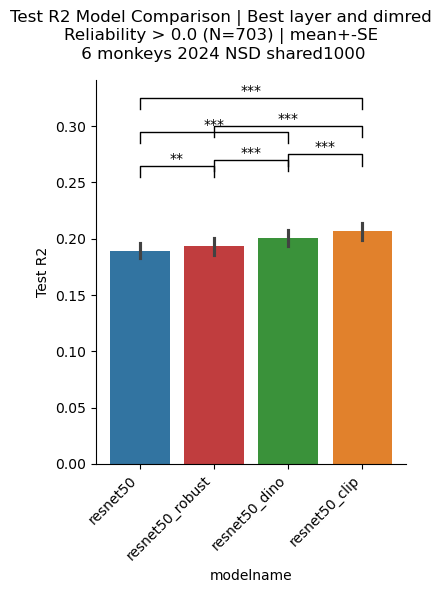

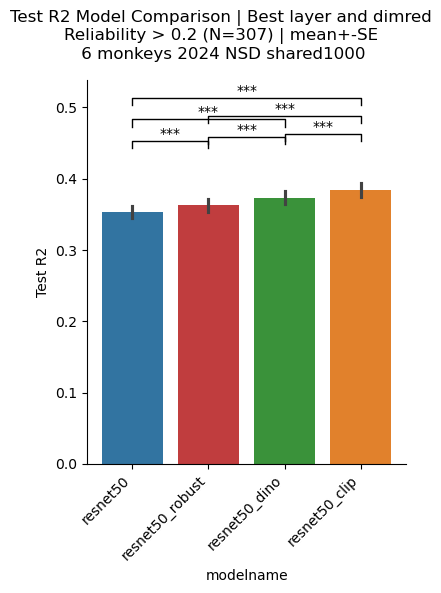

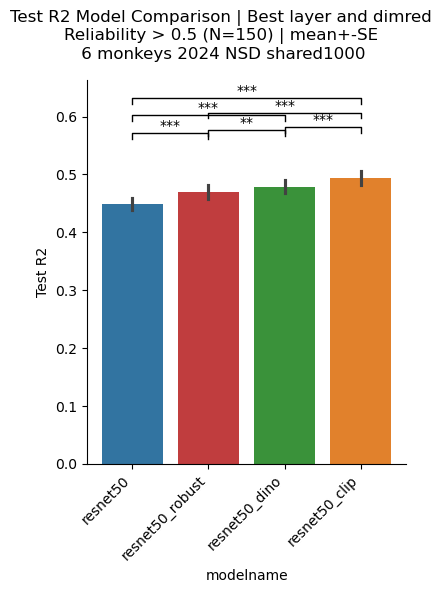

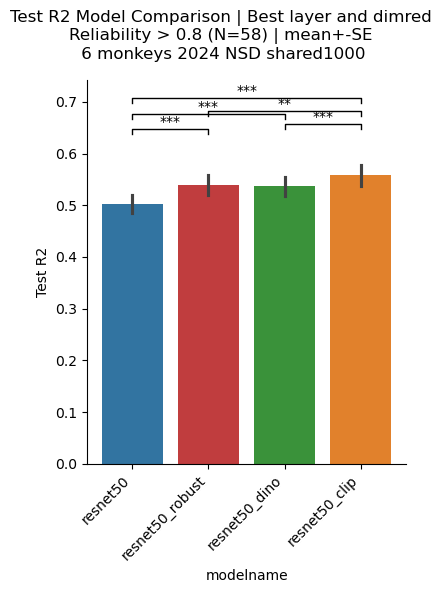

In [163]:
# Group by subject_id, unit, modelname and get max test_score
models = ["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip"]
for thresh in [0.0, 0.2, 0.5, 0.8]:
    best_scores = df.query("reliability > @thresh").groupby(['subject_id', 'unit', 'modelname'])['test_score'].max().reset_index()
    pivot_scores = best_scores.pivot(index=['subject_id', 'unit'], columns='modelname', values='test_score')
    n_units = len(best_scores.groupby(['subject_id', 'unit']).size())
    
    # plot the best scores as a bar plot
    plt.figure(figsize=(4, 6))
    ax = sns.barplot(data=best_scores, x="modelname", y="test_score", 
                order=["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip"],
                hue="modelname",
                errorbar="se"
                )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Test R2")
    plt.suptitle(f"Test R2 Model Comparison | Best layer and dimred\nReliability > {thresh} (N={n_units}) | mean+-SE\n 6 monkeys 2024 NSD shared1000")
    plt.tight_layout()
    saveallforms(synfigdir, f"test_r2_per_model_reliability_thr{thresh}", figh=plt.gcf())
    # Perform paired t-tests between all pairs
    y_max = ax.get_ylim()[1]
    for i in range(len(models)):
        for j in range(i+1, len(models)):
            scores1 = pivot_scores[models[i]]
            scores2 = pivot_scores[models[j]]
            t_stat, p_val = scipy.stats.ttest_rel(scores1, scores2)
            # Add significance annotation
            if p_val < 0.01:
                symbol = '***' if p_val < 0.001 else '**' if p_val < 0.01 else 'N.S.'
                y = y_max + 0.03 * (j-i) + 0.005 * i
                x1, x2 = i, j
                plt.plot([x1, x1, x2, x2], [y, y+0.01, y+0.01, y], 'k-', linewidth=1)
                plt.text((x1+x2)/2, y+0.01, symbol, ha='center', va='bottom')
    
    plt.tight_layout()
    saveallforms(synfigdir, f"test_r2_per_model_reliability_thr{thresh}_ttest_annot", figh=plt.gcf())
    plt.show()

In [151]:
# Pivot table to get modelname as columns
best_scores = df.query("reliability > 0.8").groupby(['subject_id', 'unit', 'modelname'])['test_score'].max().reset_index()
pivot_scores = best_scores.pivot(index=['subject_id', 'unit'], columns='modelname', values='test_score')
# make list of modelnames, sort by their mean test_score
modelnames = pivot_scores.columns.tolist()
modelnames.sort(key=lambda x: pivot_scores[x].mean())
pivot_scores = pivot_scores[modelnames]
# Perform paired t-tests between all model pairs
model_pairs = [(modelnames[j], modelnames[i]) for j in range(len(modelnames)) for i in range(len(modelnames)) if i < j]
print("Paired t-tests between models:")
print("-" * 40)
for m1, m2 in model_pairs:
    t_stat, p_val = scipy.stats.ttest_rel(pivot_scores[m1].dropna(), pivot_scores[m2].dropna())
    dof = len(pivot_scores[m1].dropna()) - 1
    print(f"{m1} > {m2}: t-value: {t_stat:.3f} | p-value: {p_val:.3e} | dof: {dof}")

Paired t-tests between models:
----------------------------------------
resnet50_dino > resnet50: t-value: 12.269 | p-value: 1.243e-17 | dof: 57
resnet50_robust > resnet50: t-value: 5.817 | p-value: 2.861e-07 | dof: 57
resnet50_robust > resnet50_dino: t-value: 0.428 | p-value: 6.705e-01 | dof: 57
resnet50_clip > resnet50: t-value: 9.406 | p-value: 3.378e-13 | dof: 57
resnet50_clip > resnet50_dino: t-value: 5.227 | p-value: 2.543e-06 | dof: 57
resnet50_clip > resnet50_robust: t-value: 3.066 | p-value: 3.316e-03 | dof: 57


### Across Subjects / Array and Models

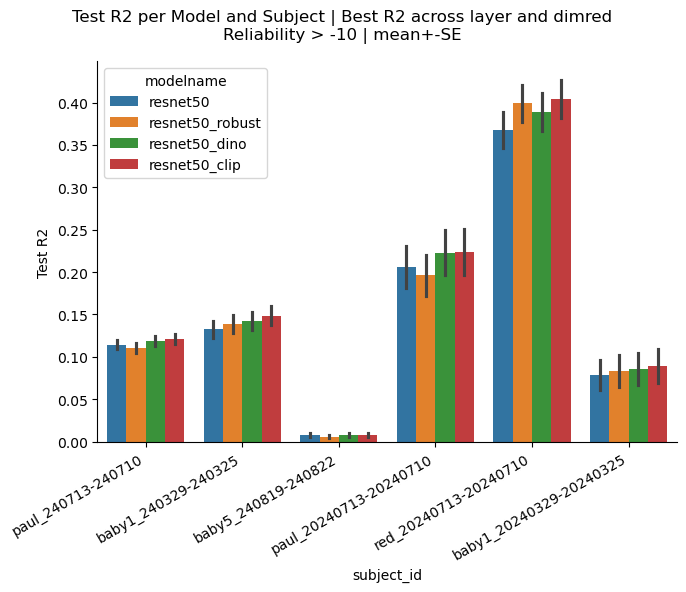

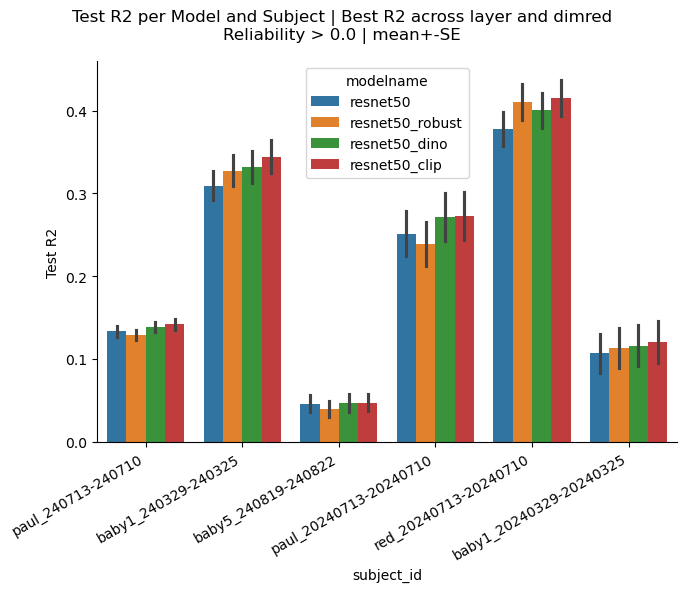

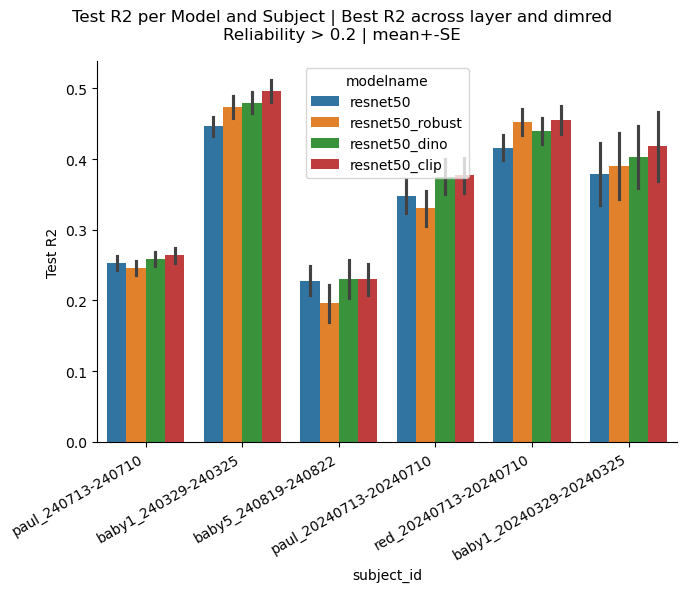

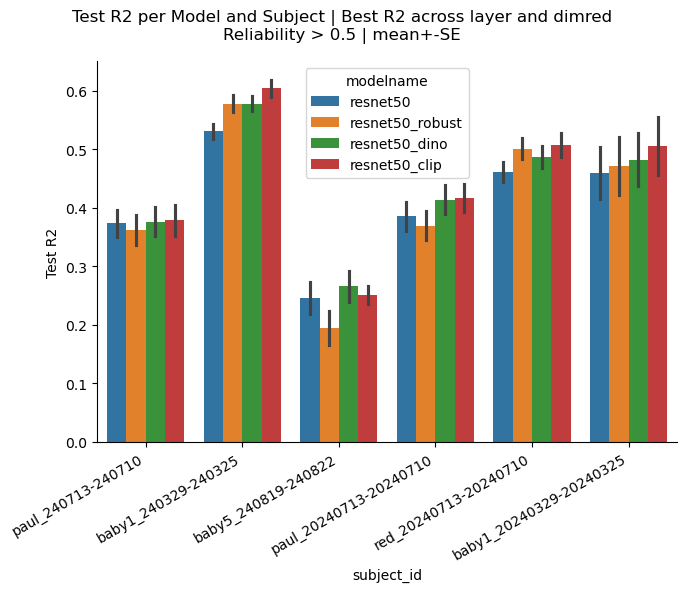

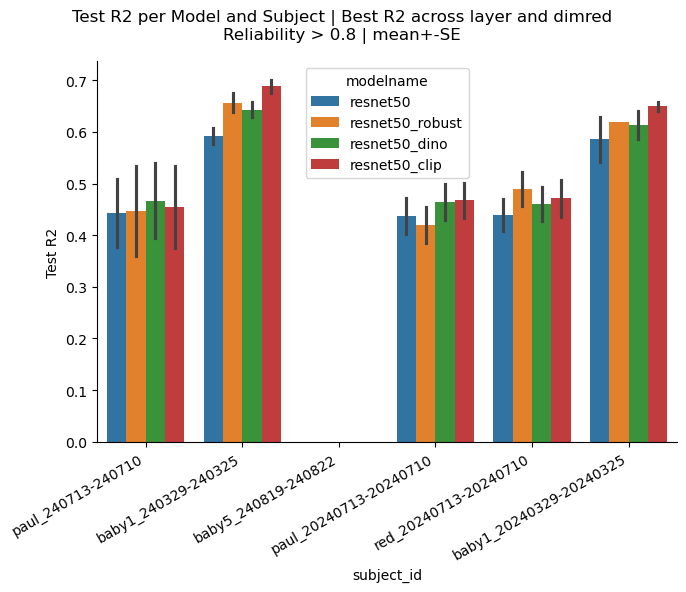

In [170]:
# Group by subject_id, unit, modelname and get max test_score
thresh = 0.2
for thresh in [-10, 0.0, 0.2, 0.5, 0.8]:
    best_scores = df.query("reliability > @thresh").groupby(['subject_id', 'unit', 'modelname'])['test_score'].max().reset_index()
    # plot the best scores as a bar plot
    plt.figure(figsize=(7, 6))
    sns.barplot(data=best_scores, x="subject_id", y="test_score", hue="modelname", 
                order=["paul_240713-240710", "baby1_240329-240325", "baby5_240819-240822", "paul_20240713-20240710", "red_20240713-20240710", "baby1_20240329-20240325", ],
                hue_order=["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip"],
                errorbar="se"
                )
    plt.xticks(rotation=30, ha='right')
    plt.ylabel("Test R2")
    plt.suptitle(f"Test R2 per Model and Subject | Best R2 across layer and dimred\nReliability > {thresh} | mean+-SE")
    plt.tight_layout()
    saveallforms(synfigdir, f"test_r2_per_model_and_subject_reliability_thr{thresh}", figh=plt.gcf())
    plt.show()

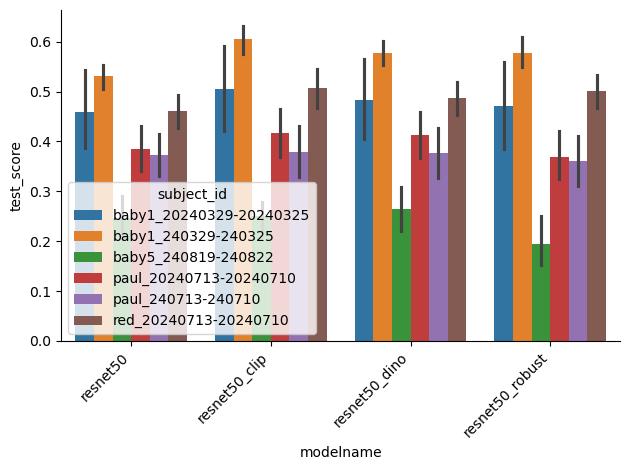

In [ ]:
# Group by subject_id, unit, modelname and get max test_score
best_scores = df.query("reliability > 0.5").groupby(['subject_id', 'unit', 'modelname'])['test_score'].max().reset_index()
# plot the best scores as a bar plot
sns.barplot(data=best_scores, x="modelname", y="test_score", hue="subject_id", )
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

### Layer comparison

In [172]:
summary_df = synopsis_xr[["test_score", "reliability", "ncsnr", "brain_area"]].to_dataframe().reset_index()

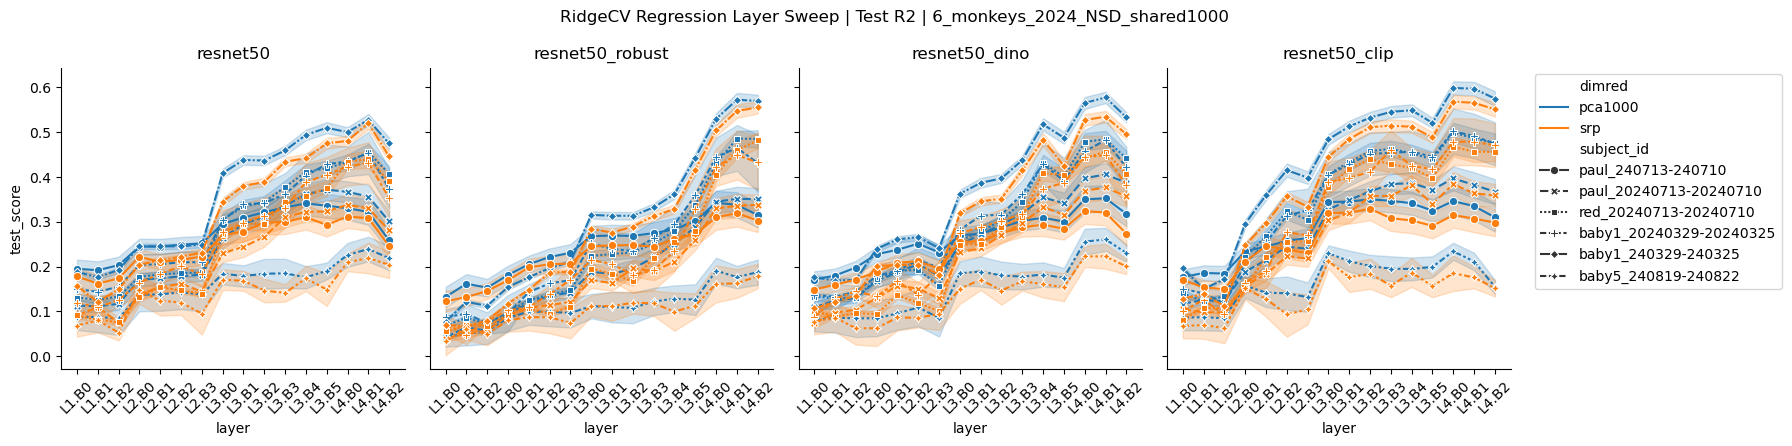

In [174]:
shorten_func = lambda x: x.replace("Bottleneck", "B").replace(".layer", "L")
fig, axes = plt.subplots(1, 4, figsize=(18, 4.5), sharey=True)
axes = axes.flatten()
for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
    subdf = summary_df.query("modelname == @modelname and reliability > 0.5")
    sns.lineplot(data=subdf, x="layer", y="test_score", 
                 hue="dimred", style="subject_id", ax=axes[i],
                 hue_order=["pca1000", "srp"],
                 errorbar="se",
                 legend=False if i < 3 else True, markers=True)
    axes[i].set_title(modelname)
    axes[i].tick_params(axis='x', rotation=45)
    # make the xticks be the layer names, simpler and more readable
    xticklabels = axes[i].get_xticklabels()
    xticklabels = [shorten_func(label.get_text()) for label in xticklabels]
    axes[i].set_xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    # axes[i].set_title("Training R2")

if axes[-1].get_legend():
    # Move legend outside the last subplot
    axes[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle("RidgeCV Regression Layer Sweep | Test R2 | 6_monkeys_2024_NSD_shared1000")
plt.tight_layout()

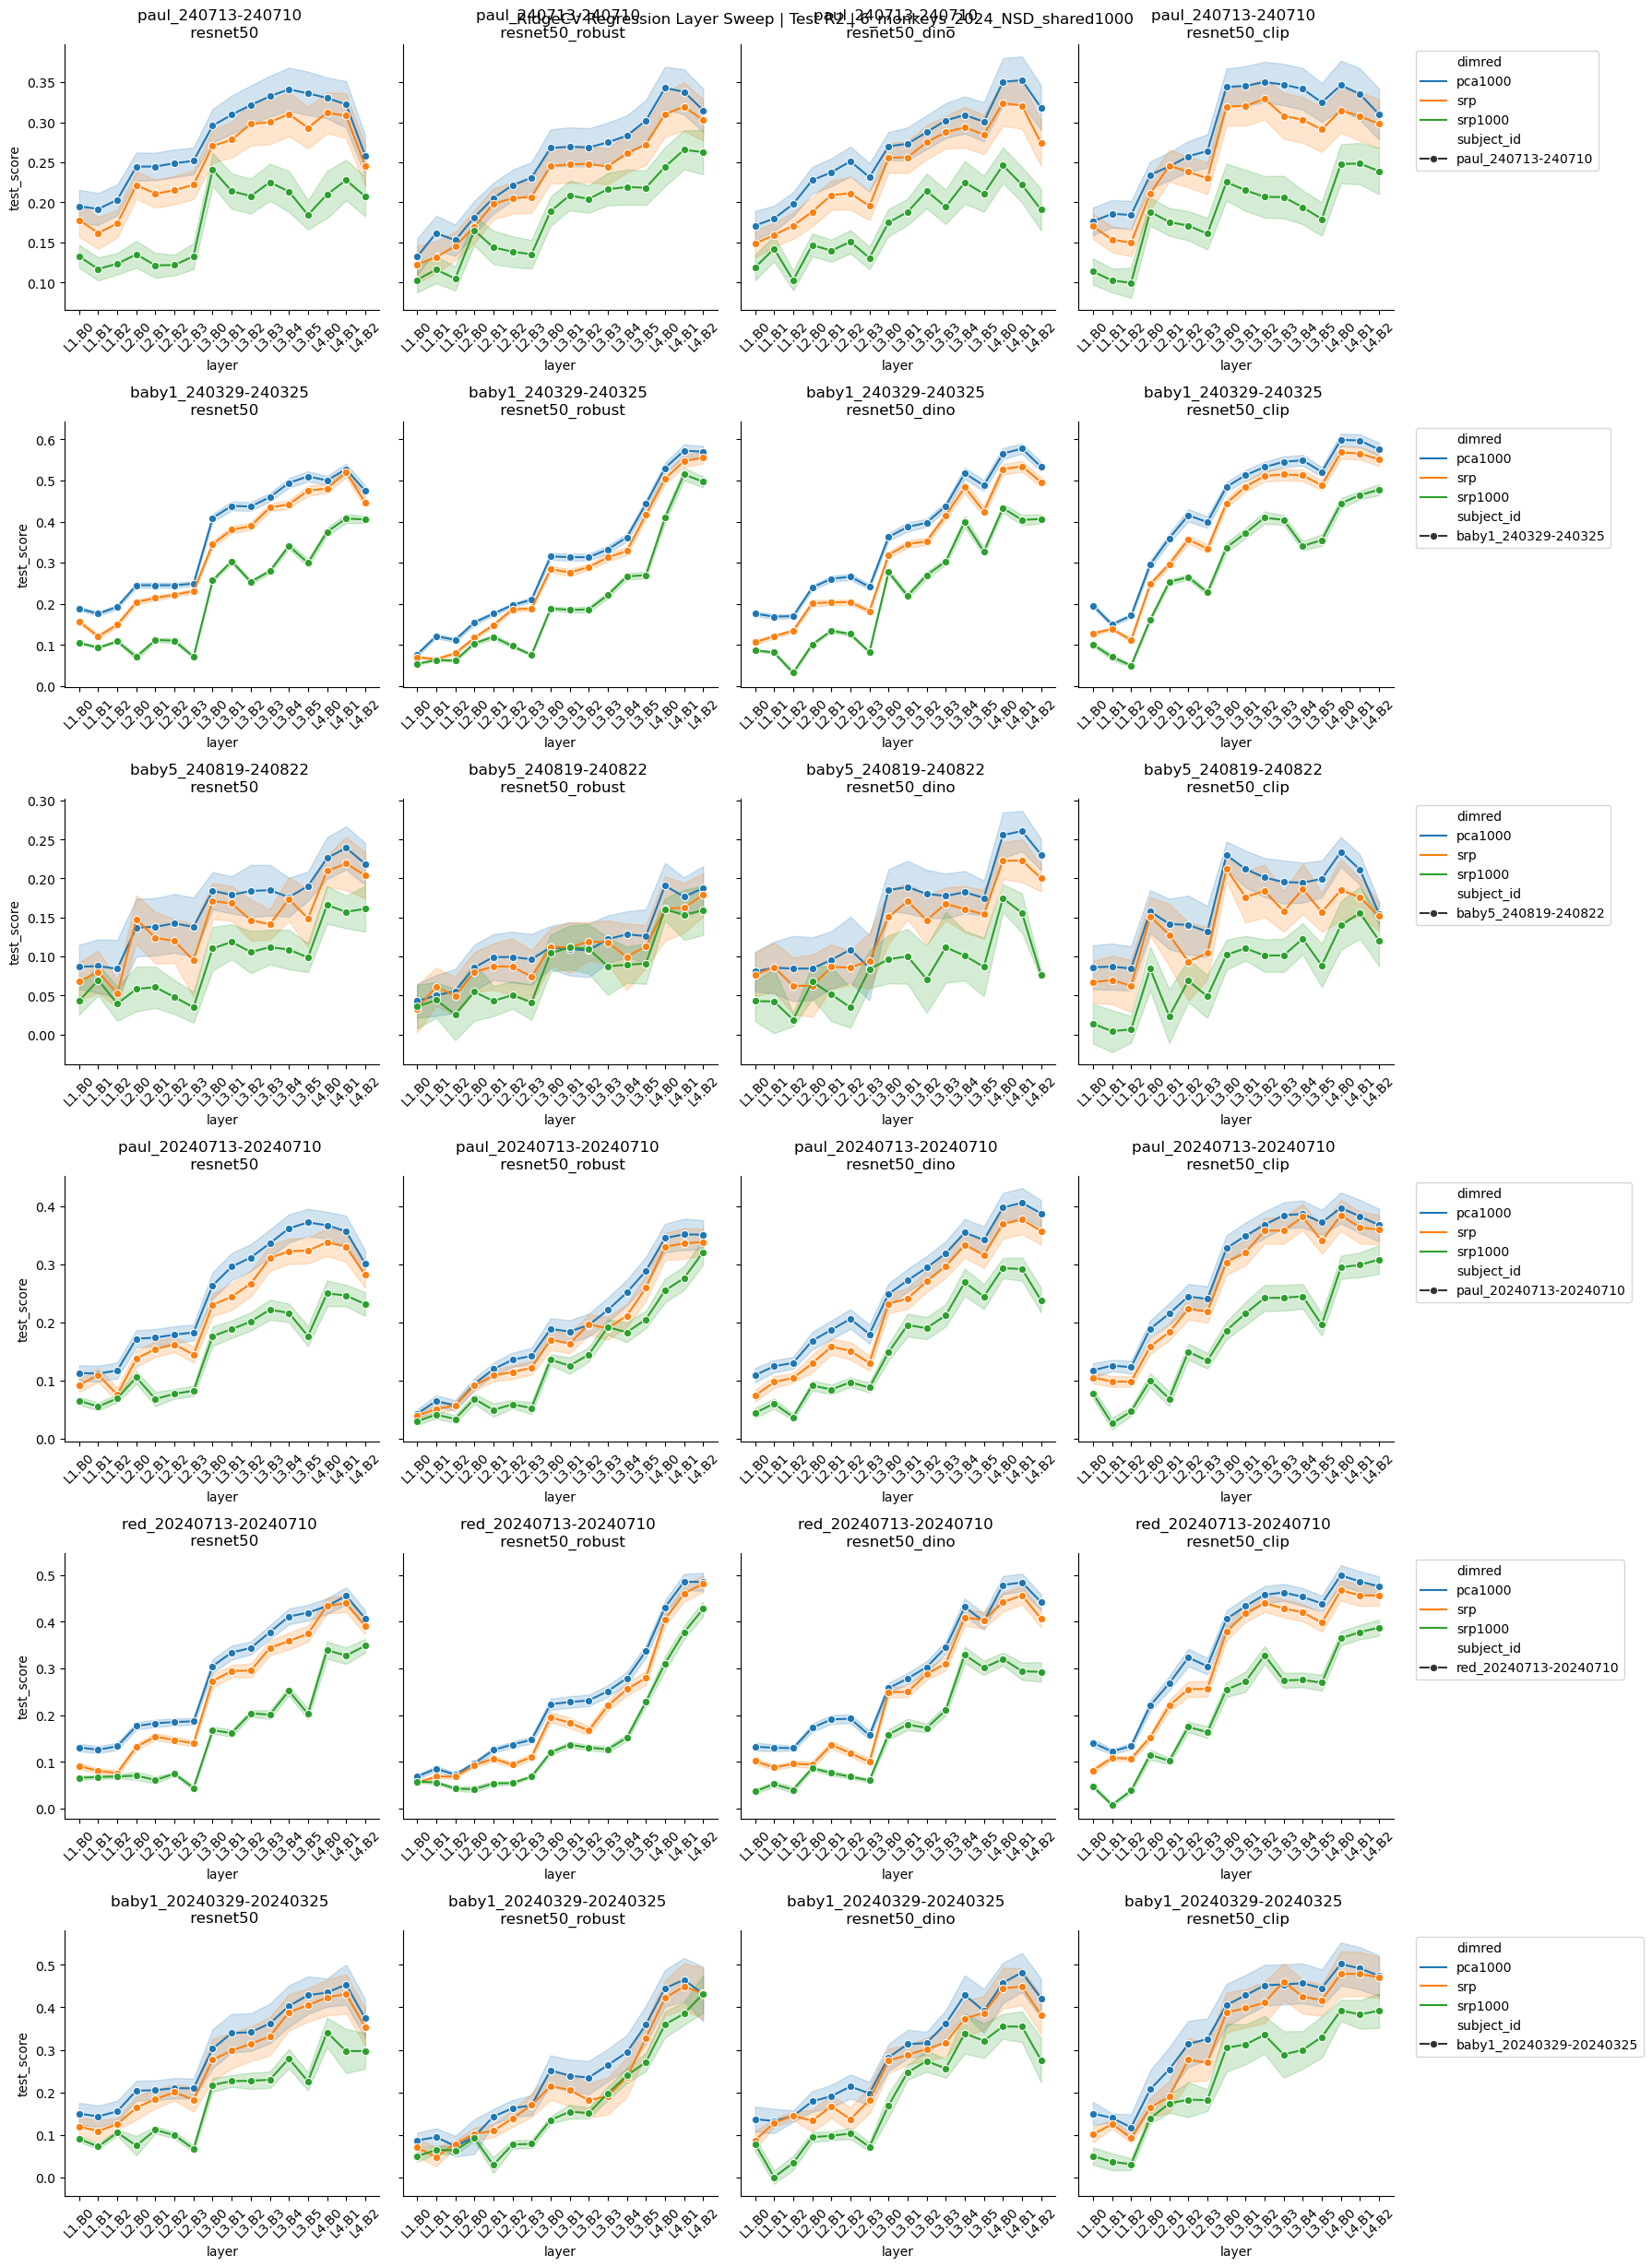

In [179]:
thresh = 0.5
shorten_func = lambda x: x.replace("Bottleneck", "B").replace(".layer", "L")
fig, axes = plt.subplots(6, 4, figsize=(18, 25), sharey="row")
for j, subject_id in enumerate(["paul_240713-240710", "baby1_240329-240325", "baby5_240819-240822", "paul_20240713-20240710", "red_20240713-20240710", "baby1_20240329-20240325", ]):
    for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
        subdf = summary_df.query("modelname == @modelname and reliability > @thresh and subject_id == @subject_id")
        sns.lineplot(data=subdf, x="layer", y="test_score", 
                    hue="dimred", style="subject_id", ax=axes[j, i],
                    # hue_order=["pca1000", "srp"],
                    errorbar="se",
                    legend=False if i < 3 else True, markers=True)
        axes[j, i].set_title(f"{subject_id} \n {modelname}")
        axes[j, i].set_xlabel("")
        axes[j, i].tick_params(axis='x', rotation=45)
        # make the xticks be the layer names, simpler and more readable
        xticklabels = axes[j, i].get_xticklabels()
        xticklabels = [shorten_func(label.get_text()) for label in xticklabels]
        axes[j, i].set_xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    # axes[i].set_title("Training R2")
    if axes[j, -1].get_legend():
        # Move legend outside the last subplot
        axes[j, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle(f"RidgeCV Regression Layer Sweep | Test R2 | 6_monkeys_2024_NSD_shared1000 | Reliability > {thresh}")
plt.tight_layout()
saveallforms(synfigdir, f"test_r2_layer_curve_per_model_and_subject_reliability_thr{thresh}", figh=fig)
plt.show()

In [180]:
thresh = 0.5
shorten_func = lambda x: x.replace("Bottleneck", "B").replace(".layer", "L")
for thresh in [0.0, 0.2, 0.5, 0.8]:
    fig, axes = plt.subplots(6, 4, figsize=(18, 25), sharey="row")
    for j, subject_id in enumerate(["paul_240713-240710", "baby1_240329-240325", "baby5_240819-240822", "paul_20240713-20240710", "red_20240713-20240710", "baby1_20240329-20240325", ]):
        for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
            subdf = summary_df.query("modelname == @modelname and reliability > @thresh and subject_id == @subject_id")
            sns.lineplot(data=subdf, x="layer", y="test_score", 
                        hue="dimred", style="subject_id", ax=axes[j, i],
                        # hue_order=["pca1000", "srp"],
                        errorbar="se",
                        legend=False if i < 3 else True, markers=True)
            axes[j, i].set_title(f"{subject_id} \n {modelname}")
            axes[j, i].set_xlabel("")
            axes[j, i].tick_params(axis='x', rotation=45)
            # make the xticks be the layer names, simpler and more readable
            xticklabels = axes[j, i].get_xticklabels()
            xticklabels = [shorten_func(label.get_text()) for label in xticklabels]
            axes[j, i].set_xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
        # axes[i].set_title("Training R2")
        if axes[j, -1].get_legend():
            # Move legend outside the last subplot
            axes[j, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle(f"RidgeCV Regression Layer Sweep | Test R2 | 6_monkeys_2024_NSD_shared1000 | Reliability > {thresh}")
    plt.tight_layout()
    saveallforms(synfigdir, f"test_r2_layer_curve_per_model_and_subject_reliability_thr{thresh}", figh=fig)
    plt.close()

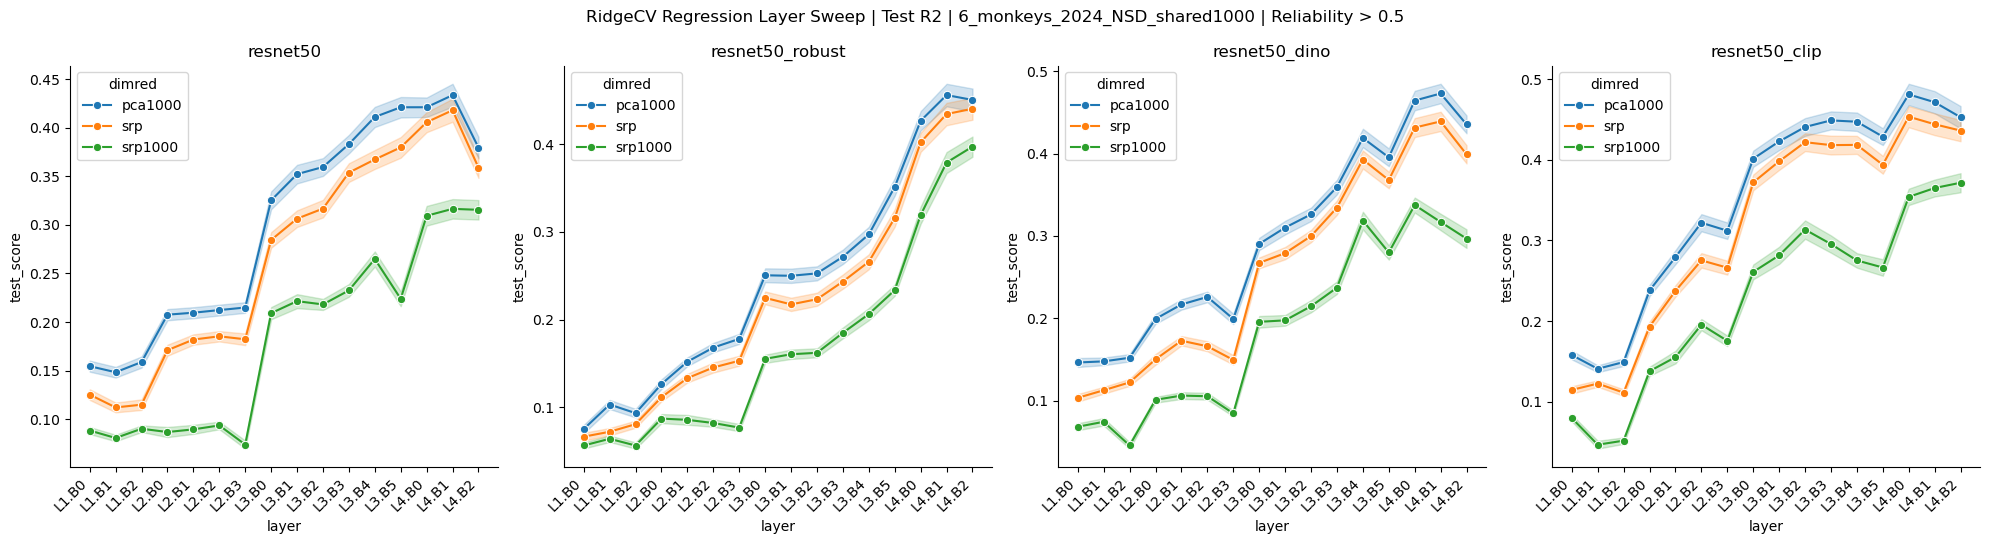

In [229]:
thresh = 0.5
fig, axes = plt.subplots(1, 4, figsize=(20, 5.5))
for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip"]):
    sns.lineplot(data=df.query(f"reliability > {thresh} and modelname == @modelname"), 
                x="layer", y="test_score", hue="dimred",  errorbar='se', #style="subject_id",
                markers=True, ax=axes[i], marker='o')
    axes[i].set_title(modelname)
    xticklabels = axes[i].get_xticklabels()
    axes[i].set_xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45, ha='right')

plt.suptitle(f"RidgeCV Regression Layer Sweep | Test R2 | 6_monkeys_2024_NSD_shared1000 | Reliability > {thresh}")
plt.tight_layout()
# saveallforms(synfigdir, f"test_r2_layer_curve_per_model_unit_avg_reliability_thr{thresh}", figh=fig)
plt.show()

In [230]:
for thresh in [0.0, 0.2, 0.5, 0.8]:
    fig, axes = plt.subplots(1, 4, figsize=(20, 5.5))
    for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip"]):
        sns.lineplot(data=df.query(f"reliability > {thresh} and modelname == @modelname"), 
                    x="layer", y="test_score", hue="dimred",  errorbar='se', #style="subject_id",
                    markers=True, ax=axes[i], marker='o')
        axes[i].set_title(modelname)
        xticklabels = axes[i].get_xticklabels()
        axes[i].set_xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45, ha='right')

    plt.suptitle(f"RidgeCV Regression Layer Sweep | Test R2 | 6_monkeys_2024_NSD_shared1000 | Reliability > {thresh}")
    plt.tight_layout()
    saveallforms(synfigdir, f"test_r2_layer_curve_per_model_unit_avg_reliability_thr{thresh}", figh=fig)
    plt.close()

### Distribution of best predicting layer

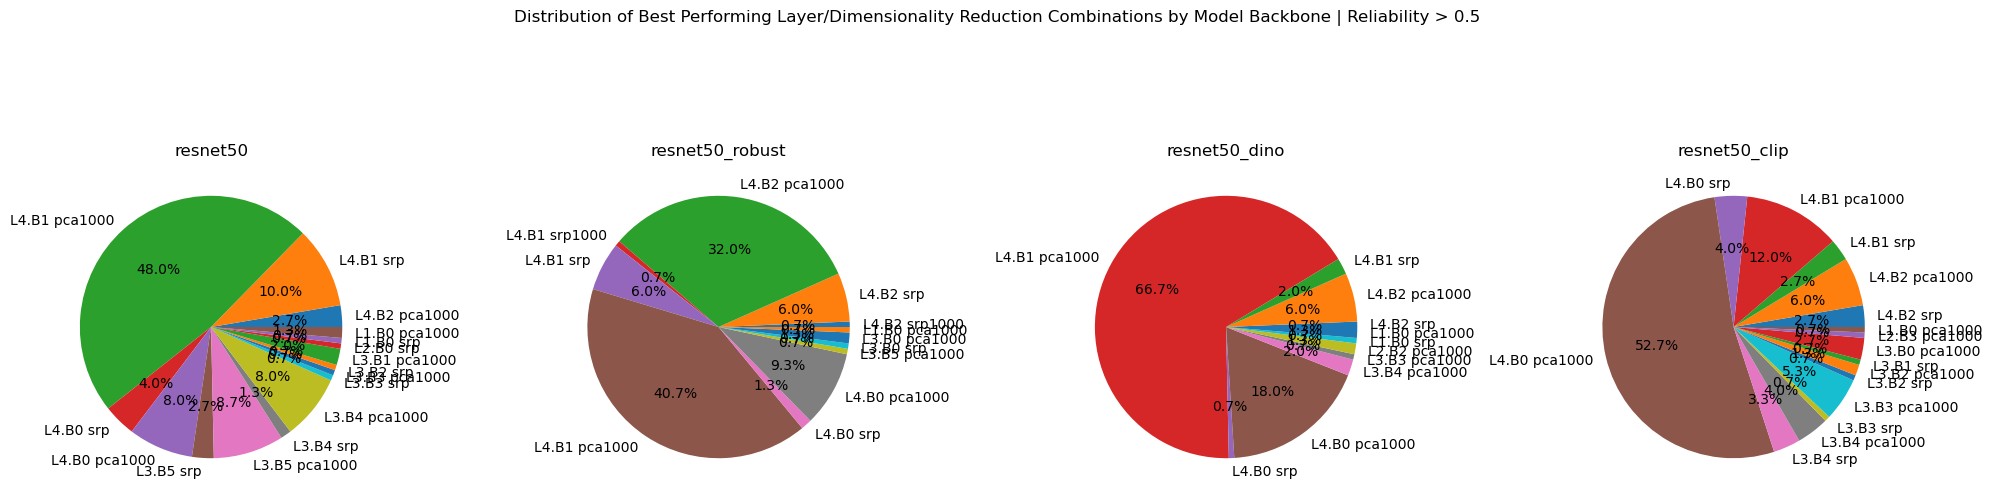

In [202]:
thresh = 0.5
# Get best layer/dimred combo for each subject_id and unit
best_configs = summary_df.query("reliability > @thresh").groupby(['modelname', 'subject_id', 'unit']).apply(
    lambda x: x.loc[x['test_score'].idxmax(), ['layer', 'dimred']], include_groups=False
).reset_index()
# Create subplots for each model
fig, axes = plt.subplots(1, 4, figsize=(20, 5.5))
axes = axes.ravel()
for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
    # Filter for current model
    model_configs = best_configs.query("modelname == @modelname")
    # Count occurrences of each layer/dimred combination
    config_counts = model_configs.groupby(['layer', 'dimred']).size().sort_index(ascending=False)
    # Create pie chart in subplot
    axes[i].pie(config_counts, 
                labels=[f"{layer} {dimred}" for layer,dimred in config_counts.index],
                autopct='%1.1f%%')
    axes[i].set_title(f"{modelname}")

plt.suptitle(f"Distribution of Best Performing Layer/Dimensionality Reduction Combinations by Model Backbone | Reliability > {thresh}", y=1.05)
plt.tight_layout()
plt.show()

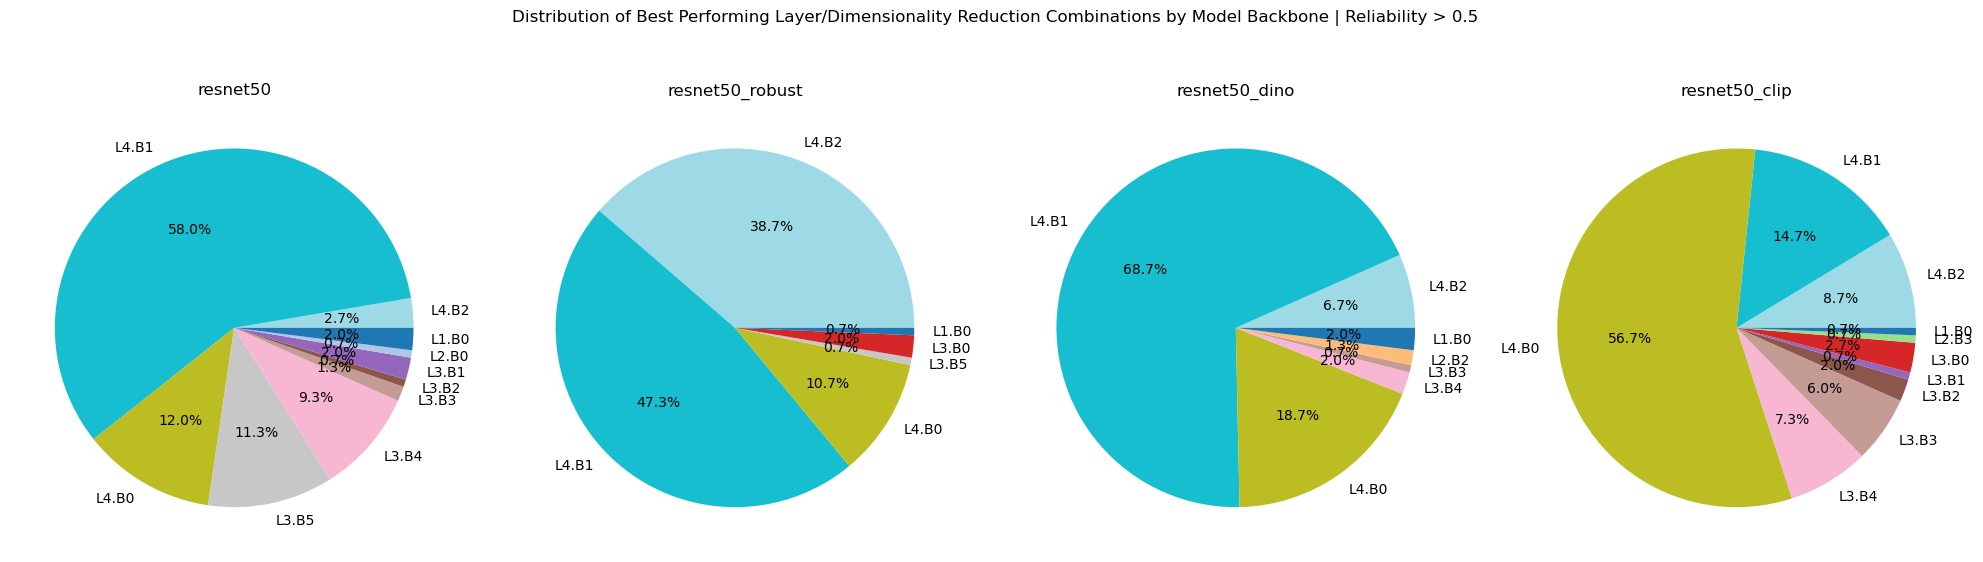

In [232]:
thresh = 0.5
# Get best layer/dimred combo for each subject_id and unit
best_configs = summary_df.query("reliability > @thresh").groupby(['modelname', 'subject_id', 'unit']).apply(
    lambda x: x.loc[x['test_score'].idxmax(), ['layer', 'dimred']], include_groups=False
).reset_index()
all_layers = sorted(list(best_configs["layer"].unique()))
colors = plt.cm.tab20(np.linspace(0, 1, len(all_layers)))
color_dict = dict(zip(all_layers, colors))
# Create subplots for each model
fig, axes = plt.subplots(1, 4, figsize=(20, 5.5))
axes = axes.ravel()
for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
    # Filter for current model
    model_configs = best_configs.query("modelname == @modelname")
    # Count occurrences of each layer/dimred combination
    config_counts = model_configs.groupby(['layer',]).size().sort_index(ascending=False)
    # Create pie chart in subplot
    plot_colors = [color_dict[layer] for layer in config_counts.index]
    axes[i].pie(config_counts, 
                labels=[f"{layer}" for layer in config_counts.index],
                autopct='%1.1f%%',
                colors=plot_colors)
    axes[i].set_title(f"{modelname}")

plt.suptitle(f"Distribution of Best Performing Layer/Dimensionality Reduction Combinations by Model Backbone | Reliability > {thresh}", y=1.05)
plt.tight_layout()
saveallforms(synfigdir, f"best_layer_distribution_by_model_allunits_reliability_thr{thresh}", figh=fig)
plt.show()

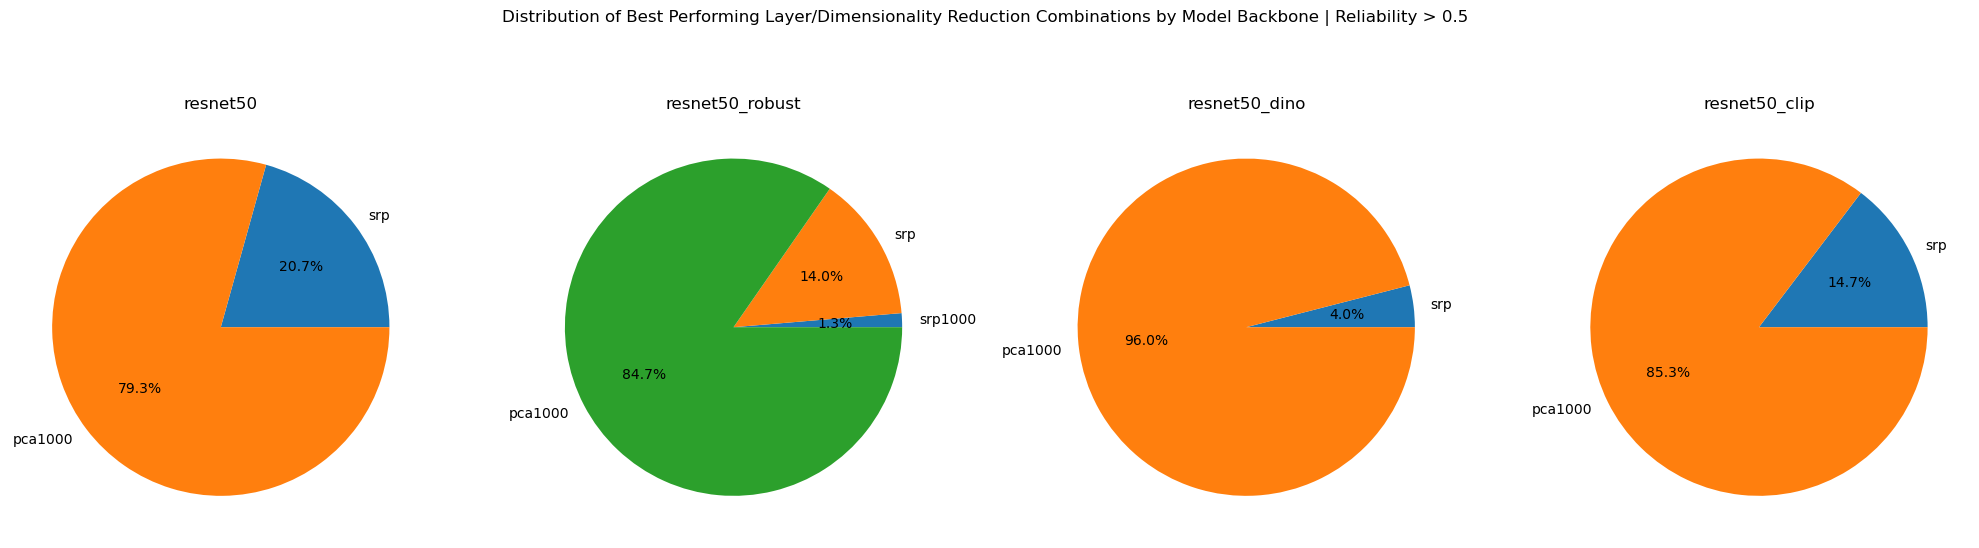

In [205]:
thresh = 0.5
# Get best layer/dimred combo for each subject_id and unit
best_configs = summary_df.query("reliability > @thresh").groupby(['modelname', 'subject_id', 'unit']).apply(
    lambda x: x.loc[x['test_score'].idxmax(), ['layer', 'dimred']], include_groups=False
).reset_index()
# Create subplots for each model
fig, axes = plt.subplots(1, 4, figsize=(20, 5.5))
axes = axes.ravel()
for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
    # Filter for current model
    model_configs = best_configs.query("modelname == @modelname")
    # Count occurrences of each layer/dimred combination
    config_counts = model_configs.groupby(['dimred',]).size()
    # Create pie chart in subplot
    axes[i].pie(config_counts, 
                labels=[f"{dimred}" for dimred in config_counts.index],
                autopct='%1.1f%%')
    axes[i].set_title(f"{modelname}")

plt.suptitle(f"Distribution of Best Performing Layer/Dimensionality Reduction Combinations by Model Backbone | Reliability > {thresh}", y=1.05)
plt.tight_layout()
plt.show()

In [210]:
summary_df.query("subject_id == @subject_id")["brain_area"].unique()[0]

'r_aIT'

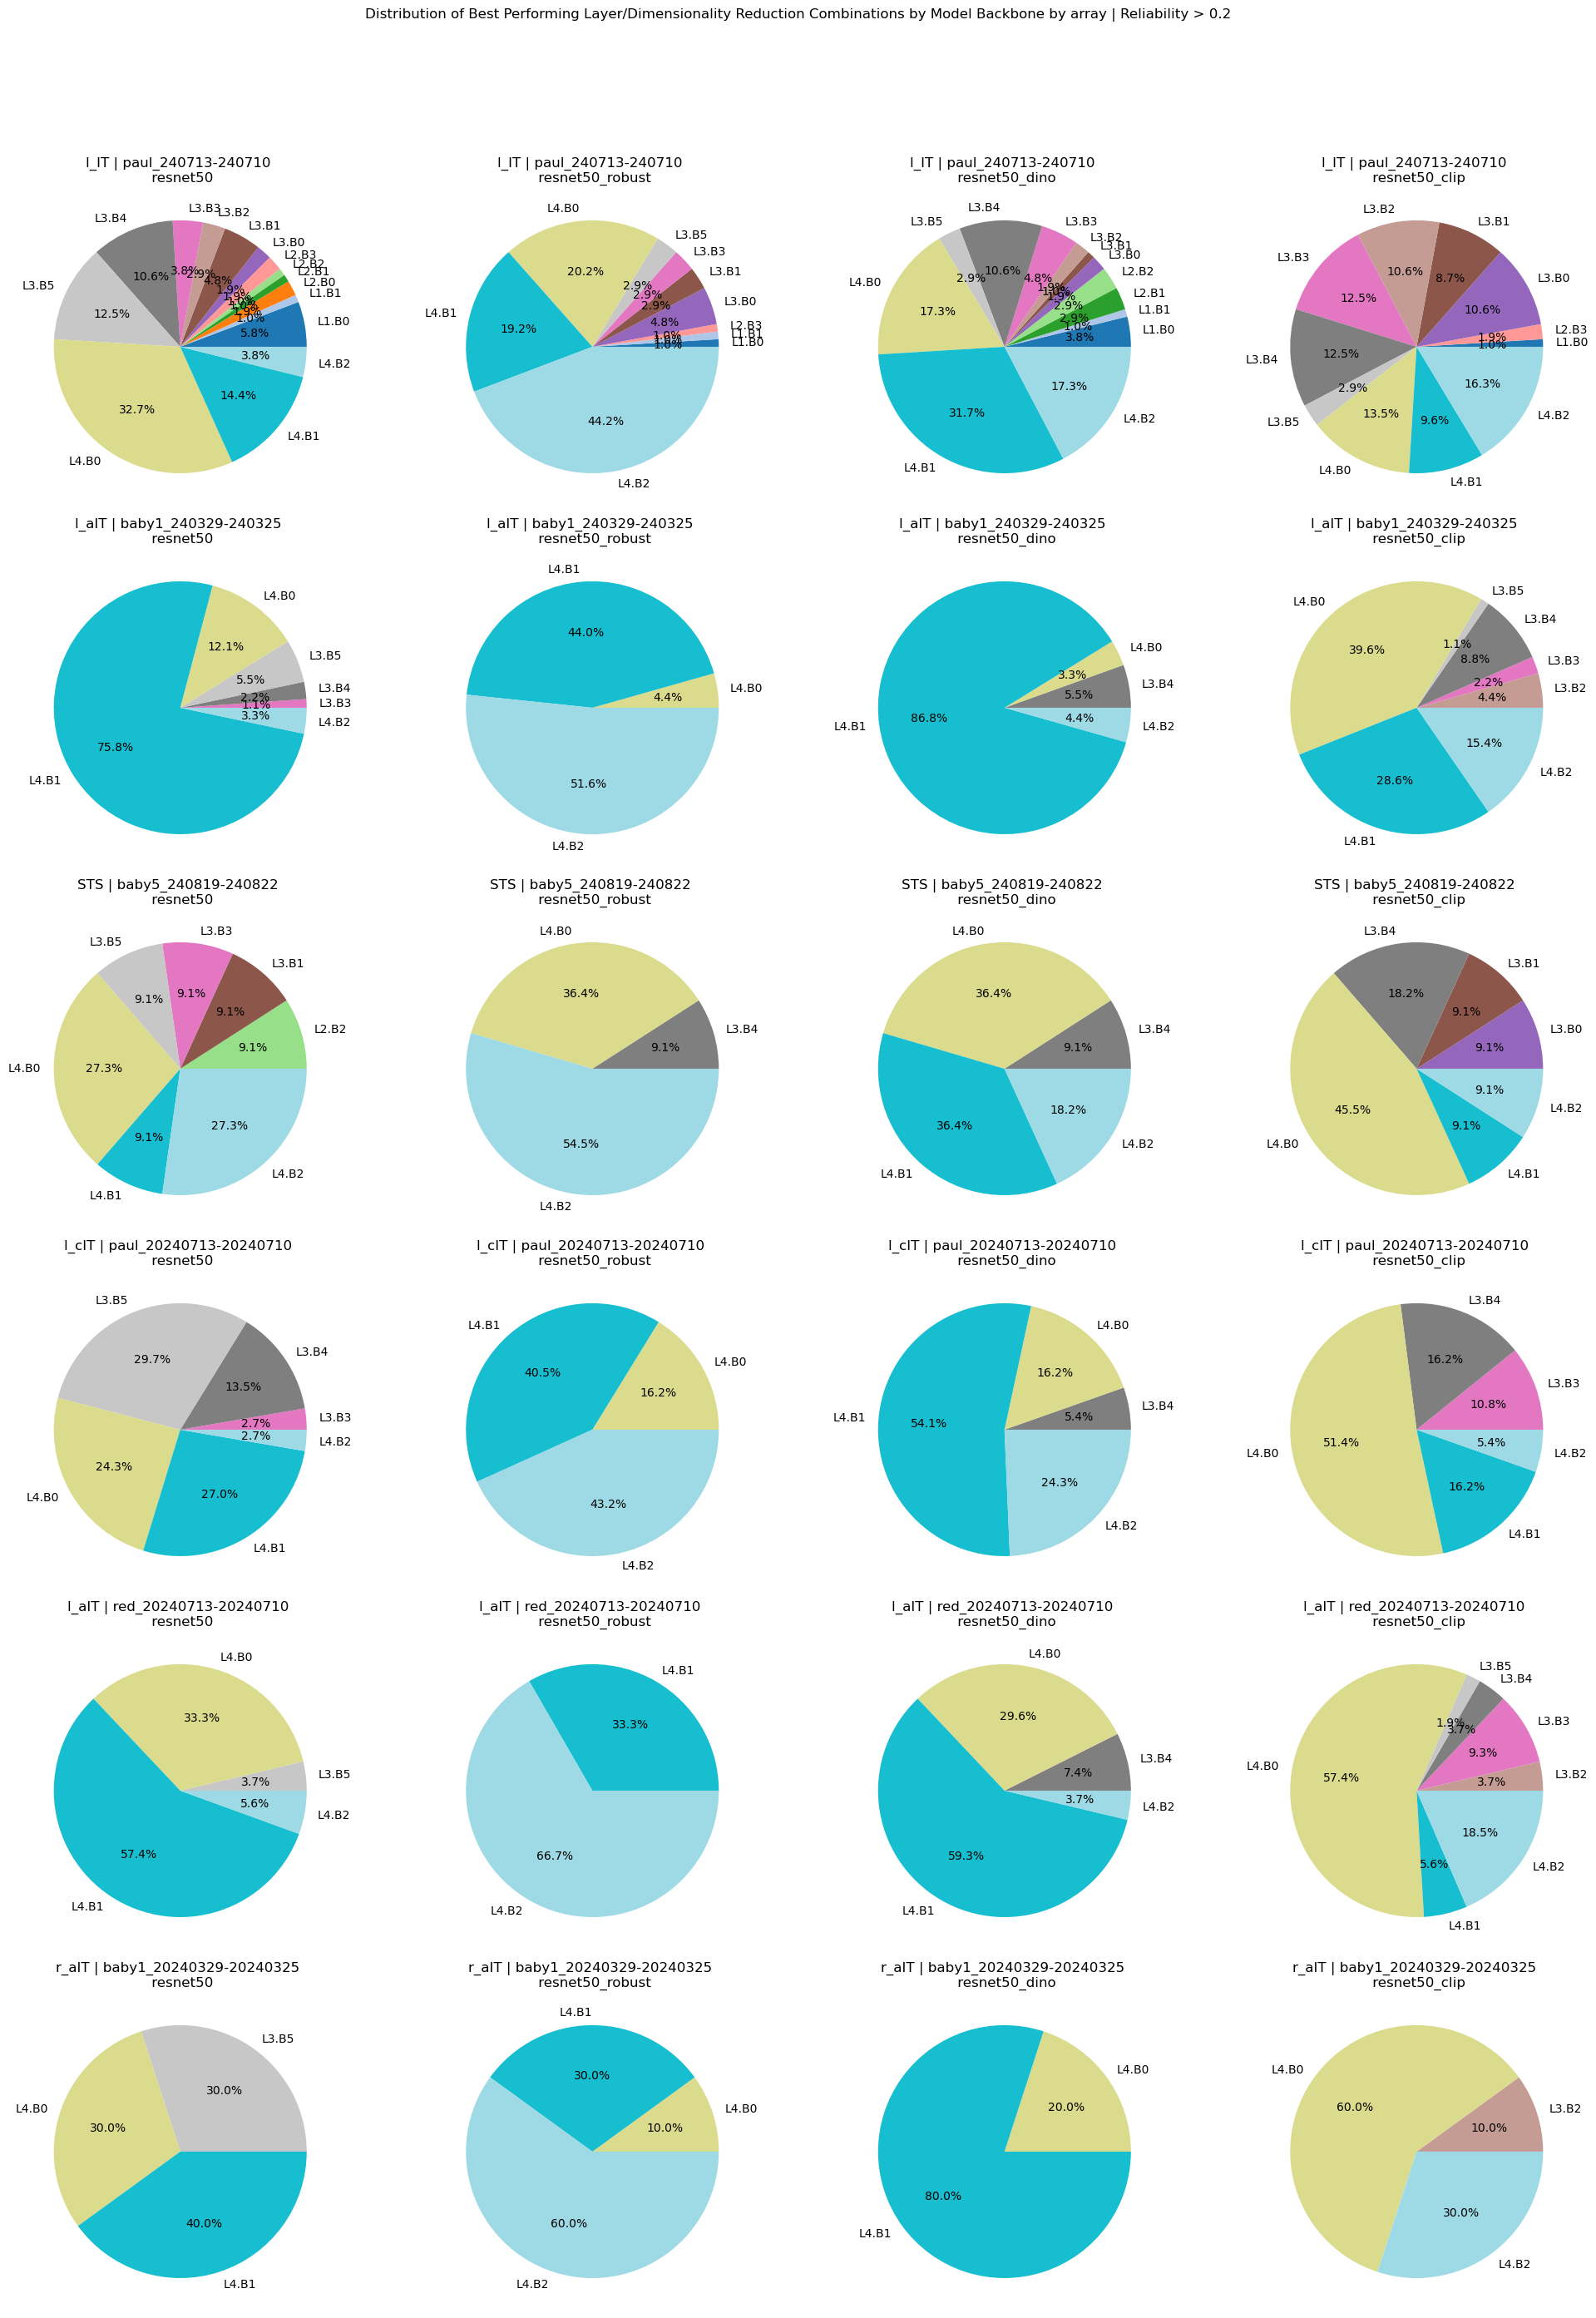

In [219]:
thresh = 0.2
# Get best layer/dimred combo for each subject_id and unit
best_configs = summary_df.query("reliability > @thresh").groupby(['modelname', 'subject_id', 'unit']).apply(
    lambda x: x.loc[x['test_score'].idxmax(), ['layer', 'dimred']], include_groups=False
).reset_index()
# Create subplots for each model
fig, axes = plt.subplots(6, 4, figsize=(20, 26.5))
all_layers = sorted(list(best_configs["layer"].unique()))
colors = plt.cm.tab20(np.linspace(0, 1, len(all_layers)))
color_dict = dict(zip(all_layers, colors))
# axes = axes.ravel()
for j, subject_id in enumerate(["paul_240713-240710", "baby1_240329-240325", "baby5_240819-240822", "paul_20240713-20240710", "red_20240713-20240710", "baby1_20240329-20240325", ]):
    brain_area = summary_df.query("subject_id == @subject_id")["brain_area"].unique()[0]
    for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
        # Filter for current model
        model_configs = best_configs.query("modelname == @modelname and subject_id == @subject_id")
        # Count occurrences of each layer/dimred combination
        config_counts = model_configs.groupby(['layer',]).size()#.sort_index(ascending=False)
        # Get colors for layers present in this config
        plot_colors = [color_dict[layer] for layer in config_counts.index]
        # Create pie chart in subplot
        axes[j, i].pie(config_counts, 
                    labels=[f"{layer}" for layer in config_counts.index],
                    autopct='%1.1f%%',
                    colors=plot_colors)
        axes[j, i].set_title(f"{brain_area} | {subject_id} \n {modelname}")

plt.suptitle(f"Distribution of Best Performing Layer/Dimensionality Reduction Combinations by Model Backbone by array | Reliability > {thresh}", y=1.05)
plt.tight_layout()
plt.show()

In [220]:
for thresh in [0.0, 0.2, 0.5, 0.8]:
    # Get best layer/dimred combo for each subject_id and unit
    best_configs = summary_df.query("reliability > @thresh").groupby(['modelname', 'subject_id', 'unit']).apply(
        lambda x: x.loc[x['test_score'].idxmax(), ['layer', 'dimred']], include_groups=False
    ).reset_index()
    # to ensure a consistent color scheme, sort the layers and make color mapping 
    all_layers = sorted(list(best_configs["layer"].unique()))
    colors = plt.cm.tab20(np.linspace(0, 1, len(all_layers)))
    color_dict = dict(zip(all_layers, colors))
    # Create subplots for each model
    fig, axes = plt.subplots(6, 4, figsize=(20, 26.5))
    for j, subject_id in enumerate(["paul_240713-240710", "baby1_240329-240325", "baby5_240819-240822", "paul_20240713-20240710", "red_20240713-20240710", "baby1_20240329-20240325", ]):
        brain_area = summary_df.query("subject_id == @subject_id")["brain_area"].unique()[0]
        for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
            # Filter for current model
            model_configs = best_configs.query("modelname == @modelname and subject_id == @subject_id")
            # Count occurrences of each layer/dimred combination
            config_counts = model_configs.groupby(['layer',]).size()#.sort_index(ascending=False)
            # Get colors for layers present in this config
            plot_colors = [color_dict[layer] for layer in config_counts.index]
            # Create pie chart in subplot
            axes[j, i].pie(config_counts, 
                        labels=[f"{layer}" for layer in config_counts.index],
                        autopct='%1.1f%%',
                        colors=plot_colors)
            axes[j, i].set_title(f"{brain_area} | {subject_id} \n {modelname}")

    plt.suptitle(f"Distribution of Best Performing Layer/Dimensionality Reduction Combinations by Model Backbone by array | Reliability > {thresh}", y=1.05)
    plt.tight_layout()
    saveallforms(synfigdir, f"best_layer_distribution_by_model_and_array_reliability_thr{thresh}", figh=fig)
    plt.close()

In [97]:
# ds = synopsis_xr.set_index(sample=("subject_id", "modelname"))
# ds = ds.unstack("sample")
ds = synopsis_xr.stack(regressors=("modelname", "layer", "dimred"))
# ds = ds.stack(units=("subject_id", "unit"))
ds

<xarray.Dataset> Size: 4MB
Dimensions:      (unit: 1341, regressors: 192)
Coordinates:
  * unit         (unit) int64 11kB 0 1 2 3 4 5 6 ... 376 377 378 379 380 381 382
    subject_id   (unit) <U23 123kB 'paul_240713-240710' ... 'baby5_240819-240...
  * regressors   (regressors) object 2kB MultiIndex
  * modelname    (regressors) <U15 12kB 'resnet50_clip' ... 'resnet50_robust'
  * layer        (regressors) object 2kB '.layer1.Bottleneck0' ... '.layer4.B...
  * dimred       (regressors) <U7 5kB 'pca1000' 'srp' ... 'srp' 'srp1000'
Data variables:
    train_score  (unit, regressors) float64 2MB 7.949e-05 ... 7.874e-05
    test_score   (unit, regressors) float64 2MB -0.001945 ... -5.109e-05
    reliability  (unit) float64 11kB -0.01984 0.1161 ... 0.008042 0.02509
    ncsnr        (unit) float32 5kB 0.0 0.08276 0.01169 ... 0.0 0.0 0.07746
    brain_area   (unit) <U5 27kB 'l_IT' 'l_IT' 'l_IT' ... 'STS' 'STS' 'STS'

In [77]:
ds

<xarray.Dataset> Size: 13MB
Dimensions:      (regressors: 192, units: 2298)
Coordinates:
  * regressors   (regressors) object 2kB MultiIndex
  * modelname    (regressors) <U15 12kB 'resnet50' ... 'resnet50_robust'
  * layer        (regressors) object 2kB '.layer1.Bottleneck0' ... '.layer4.B...
  * dimred       (regressors) object 2kB 'pca1000' 'srp' ... 'srp' 'srp1000'
  * units        (units) object 18kB MultiIndex
  * subject_id   (units) <U23 211kB 'baby1_20240329-20240325' ... 'red_202407...
  * unit         (units) int64 18kB 0 1 2 3 4 5 6 ... 377 378 379 380 381 382
Data variables:
    train_score  (regressors, units) float64 4MB 0.7473 0.181 0.7344 ... nan nan
    test_score   (regressors, units) float64 4MB 0.1765 0.007412 ... nan nan
    reliability  (regressors, units) float64 4MB 0.652 -0.01105 ... nan nan
    ncsnr        (regressors, units) float32 2MB 0.3793 0.0 0.6217 ... nan nan

In [75]:
synopsis_xr

<xarray.Dataset> Size: 7MB
Dimensions:      (sample: 24, layer: 16, dimred: 3, unit: 383)
Coordinates:
  * layer        (layer) object 128B '.layer1.Bottleneck0' ... '.layer4.Bottl...
  * dimred       (dimred) object 24B 'pca1000' 'srp' 'srp1000'
  * unit         (unit) int64 3kB 0 1 2 3 4 5 6 ... 376 377 378 379 380 381 382
    modelname    (sample) <U15 1kB 'resnet50_clip' ... 'resnet50_robust'
    subject_id   (sample) <U23 2kB 'paul_240713-240710' ... 'baby5_240819-240...
Dimensions without coordinates: sample
Data variables:
    train_score  (sample, layer, dimred, unit) float64 4MB 7.949e-05 ... 7.87...
    test_score   (sample, layer, dimred, unit) float64 4MB -0.001945 ... -5.1...
    reliability  (sample, unit) float64 74kB -0.01984 0.1161 ... 0.02509
    ncsnr        (sample, unit) float32 37kB 0.0 0.08276 0.01169 ... 0.0 0.07746

In [63]:
subjects = ['paul_240713-240710', 
           'paul_20240713-20240710', 
           'red_20240713-20240710',
           'baby1_20240329-20240325', 
           'baby1_240329-240325', 
           'baby5_240819-240822']

modelnames = ["resnet50_clip", "resnet50_dino", "resnet50", "resnet50_robust"]

all_test_R2_xrs = []

for subject_id in subjects:
    data_dict = load_neural_data(data_path, subject_id, stimroot)
    image_fps = data_dict['image_fps']
    resp_mat = data_dict['resp_mat']
    reliability = data_dict['reliability'] 
    ncsnr = data_dict['ncsnr']
    figdir = join(dataroot, subject_id, "model_outputs")
    
    for modelname in modelnames:
        pred_D2_dict = pkl.load(open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "rb"))
        result_df_lyrswp = pd.read_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
        result_df_formatted = format_result_df(result_df_lyrswp)

        layers = result_df_formatted['layer'].unique()
        dimreds = result_df_formatted['dimred'].unique()
        layers_short = [shorten_func(layer) for layer in layers]
        D2_per_unit_train_dict = pred_D2_dict['D2_per_unit_train_dict']
        D2_per_unit_test_dict = pred_D2_dict['D2_per_unit_test_dict']
        channel_total = len(reliability)
        
        test_R2_xr = xr.DataArray(
            data=np.array([D2_per_unit_test_dict[f"{layer}_{dimred}", "RidgeCV"] 
                        for layer in layers 
                        for dimred in dimreds]).reshape(len(layers), len(dimreds), -1),
            dims=['layer', 'dimred', 'unit'],
            coords={
                'layer': layers_short,
                'dimred': dimreds,
                'unit': np.arange(channel_total),
                'subject_id': subject_id,
                'modelname': modelname
            }
        )
        all_test_R2_xrs.append(test_R2_xr)

# Combine all DataArrays
combined_test_R2_xr = xr.concat(all_test_R2_xrs, dim='sample')

In [74]:
combined_test_R2_xr

<xarray.DataArray (layer: 16, dimred: 3, unit: 5364)> Size: 2MB
array([[[-1.94495686e-03,  3.29753117e-02, -2.13886228e-02, ...,
         -6.08270668e-06, -7.57592131e-04, -7.48515641e-05],
        [-1.94398861e-03,  2.86665171e-02, -3.05241240e-02, ...,
         -6.69726555e-06, -7.57007279e-04, -7.55311814e-05],
        [-2.65676777e-03,  3.77864002e-03, -6.84644167e-04, ...,
         -5.66488566e-06, -7.55268332e-04, -7.47907820e-05]],

       [[-1.94440990e-03,  2.66795620e-02, -6.06732294e-03, ...,
         -6.56656128e-06, -7.58555743e-04, -1.12965634e-02],
        [-1.94771349e-03,  1.50018811e-02, -9.72332658e-03, ...,
         -7.79761645e-06, -7.57410427e-04, -1.49147102e-03],
        [-1.60540643e-03,  1.08987942e-02, -3.82805030e-03, ...,
         -6.36018523e-04, -7.59325955e-04, -1.83200994e-03]],

       [[-2.06568175e-03,  2.98245313e-02, -1.59632567e-02, ...,
         -7.80565008e-06, -7.57222817e-04, -1.49528700e-02],
        [-1.94672255e-03,  1.67329264e-02, -3.66148401e-03, ...,
         -7.27740966e-06, -7.57160478e-04, -1.47256063e-02],
        [-1.94832847e-03,  1.02056955e-02, -3.29423071e-03, ...,
         -1.80117673e-06, -7.58021594e-04, -1.88105517e-02]],
...
       [[-2.95321306e-03,  1.36681040e-01, -4.09070605e-03, ...,
          1.89432085e-06, -7.64914075e-04, -8.11197976e-04],
        [-3.24363060e-03,  1.18117370e-01, -4.57290332e-03, ...,
          1.90990358e-06, -7.65035015e-04, -5.02990740e-03],
        [-4.46322565e-03,  1.21093476e-01, -1.62759820e-02, ...,
          1.64343642e-06, -7.63981987e-04, -6.45569522e-05]],

       [[-6.04186523e-03,  1.42772738e-01,  3.71931128e-03, ...,
          3.75593002e-06, -7.65241204e-04, -6.13436001e-04],
        [-5.87117798e-03,  1.29220994e-01,  6.71088720e-03, ...,
          3.50906381e-06, -7.66468484e-04, -7.84683875e-04],
        [-5.29918819e-03,  1.18999650e-01,  6.05271146e-03, ...,
          4.33923414e-06, -7.61987215e-04, -5.84730547e-05]],

       [[-1.20357896e-02,  1.44539433e-01,  8.64652131e-03, ...,
          1.32298288e-05, -7.61322467e-04,  6.27600424e-04],
        [-1.33267975e-02,  1.49351498e-01,  1.07659570e-02, ...,
          1.13871816e-05, -7.59436608e-04,  2.06732719e-04],
        [-1.72658677e-02,  1.10139638e-01,  6.08964063e-03, ...,
          1.82467607e-05, -7.62272618e-04, -5.10911426e-05]]])
Coordinates:
  * layer       (layer) <U5 320B 'L1.B0' 'L1.B1' 'L1.B2' ... 'L4.B1' 'L4.B2'
  * dimred      (dimred) object 24B 'pca1000' 'srp' 'srp1000'
  * unit        (unit) int64 43kB 0 1 2 3 4 5 6 ... 376 377 378 379 380 381 382
    subject_id  (unit) <U23 493kB 'paul_240713-240710' ... 'baby5_240819-240822'
    modelname   (unit) <U15 322kB 'resnet50_clip' ... 'resnet50_robust'

In [66]:
combined_test_R2_xr

<xarray.DataArray (layer: 16, dimred: 3, unit: 5364)> Size: 2MB
array([[[-1.94495686e-03,  3.29753117e-02, -2.13886228e-02, ...,
         -6.08270668e-06, -7.57592131e-04, -7.48515641e-05],
        [-1.94398861e-03,  2.86665171e-02, -3.05241240e-02, ...,
         -6.69726555e-06, -7.57007279e-04, -7.55311814e-05],
        [-2.65676777e-03,  3.77864002e-03, -6.84644167e-04, ...,
         -5.66488566e-06, -7.55268332e-04, -7.47907820e-05]],

       [[-1.94440990e-03,  2.66795620e-02, -6.06732294e-03, ...,
         -6.56656128e-06, -7.58555743e-04, -1.12965634e-02],
        [-1.94771349e-03,  1.50018811e-02, -9.72332658e-03, ...,
         -7.79761645e-06, -7.57410427e-04, -1.49147102e-03],
        [-1.60540643e-03,  1.08987942e-02, -3.82805030e-03, ...,
         -6.36018523e-04, -7.59325955e-04, -1.83200994e-03]],

       [[-2.06568175e-03,  2.98245313e-02, -1.59632567e-02, ...,
         -7.80565008e-06, -7.57222817e-04, -1.49528700e-02],
        [-1.94672255e-03,  1.67329264e-02, -3.66148401e-03, ...,
         -7.27740966e-06, -7.57160478e-04, -1.47256063e-02],
        [-1.94832847e-03,  1.02056955e-02, -3.29423071e-03, ...,
         -1.80117673e-06, -7.58021594e-04, -1.88105517e-02]],
...
       [[-2.95321306e-03,  1.36681040e-01, -4.09070605e-03, ...,
          1.89432085e-06, -7.64914075e-04, -8.11197976e-04],
        [-3.24363060e-03,  1.18117370e-01, -4.57290332e-03, ...,
          1.90990358e-06, -7.65035015e-04, -5.02990740e-03],
        [-4.46322565e-03,  1.21093476e-01, -1.62759820e-02, ...,
          1.64343642e-06, -7.63981987e-04, -6.45569522e-05]],

       [[-6.04186523e-03,  1.42772738e-01,  3.71931128e-03, ...,
          3.75593002e-06, -7.65241204e-04, -6.13436001e-04],
        [-5.87117798e-03,  1.29220994e-01,  6.71088720e-03, ...,
          3.50906381e-06, -7.66468484e-04, -7.84683875e-04],
        [-5.29918819e-03,  1.18999650e-01,  6.05271146e-03, ...,
          4.33923414e-06, -7.61987215e-04, -5.84730547e-05]],

       [[-1.20357896e-02,  1.44539433e-01,  8.64652131e-03, ...,
          1.32298288e-05, -7.61322467e-04,  6.27600424e-04],
        [-1.33267975e-02,  1.49351498e-01,  1.07659570e-02, ...,
          1.13871816e-05, -7.59436608e-04,  2.06732719e-04],
        [-1.72658677e-02,  1.10139638e-01,  6.08964063e-03, ...,
          1.82467607e-05, -7.62272618e-04, -5.10911426e-05]]])
Coordinates:
  * layer       (layer) <U5 320B 'L1.B0' 'L1.B1' 'L1.B2' ... 'L4.B1' 'L4.B2'
  * dimred      (dimred) object 24B 'pca1000' 'srp' 'srp1000'
  * unit        (unit) int64 43kB 0 1 2 3 4 5 6 ... 376 377 378 379 380 381 382
    subject_id  (unit) <U23 493kB 'paul_240713-240710' ... 'baby5_240819-240822'
    modelname   (unit) <U15 322kB 'resnet50_clip' ... 'resnet50_robust'

In [64]:
combined_test_R2_xr

<xarray.DataArray (sample: 24, layer: 16, dimred: 3, unit: 383)> Size: 4MB
array([[[[-1.94495686e-03,  3.29753117e-02, -2.13886228e-02, ...,
           1.30186394e-01,  1.16374949e-01,  8.99177711e-03],
         [-1.94398861e-03,  2.86665171e-02, -3.05241240e-02, ...,
           1.94700658e-01,  1.02873414e-01,  5.48841458e-03],
         [-2.65676777e-03,  3.77864002e-03, -6.84644167e-04, ...,
           1.00187269e-01,  6.50091468e-02, -2.96226637e-04]],

        [[-1.94440990e-03,  2.66795620e-02, -6.06732294e-03, ...,
           1.86575847e-01,  1.18392961e-01,  3.42435667e-03],
         [-1.94771349e-03,  1.50018811e-02, -9.72332658e-03, ...,
           1.25234186e-01,  9.27897784e-02,  3.51144740e-03],
         [-1.60540643e-03,  1.08987942e-02, -3.82805030e-03, ...,
           1.04802525e-01,  5.53173800e-02, -5.56081895e-04]],

        [[-2.06568175e-03,  2.98245313e-02, -1.59632567e-02, ...,
           6.79726331e-02,  1.22693613e-01,  5.18615944e-03],
         [-1.94672255e-03,  1.67329264e-02, -3.66148401e-03, ...,
           1.61274780e-01,  1.06679700e-01,  6.92323166e-03],
         [-1.94832847e-03,  1.02056955e-02, -3.29423071e-03, ...,
           7.39749373e-02,  5.24508450e-02,  6.51002406e-03]],
...
        [[-6.36545746e-03, -7.25824071e-03, -4.04480423e-05, ...,
           1.89432085e-06, -7.64914075e-04, -8.11197976e-04],
         [-6.60483492e-03, -7.25932942e-03, -4.04178670e-05, ...,
           1.90990358e-06, -7.65035015e-04, -5.02990740e-03],
         [-6.09864461e-03, -7.25543814e-03, -3.79825446e-05, ...,
           1.64343642e-06, -7.63981987e-04, -6.45569522e-05]],

        [[-6.09086422e-03, -7.25931682e-03, -3.78013325e-05, ...,
           3.75593002e-06, -7.65241204e-04, -6.13436001e-04],
         [-6.01866087e-03, -7.25764760e-03, -3.70552201e-05, ...,
           3.50906381e-06, -7.66468484e-04, -7.84683875e-04],
         [-4.82768896e-03, -7.25652182e-03, -3.63474108e-05, ...,
           4.33923414e-06, -7.61987215e-04, -5.84730547e-05]],

        [[-5.89650678e-03, -7.26740514e-03, -3.23610069e-05, ...,
           1.32298288e-05, -7.61322467e-04,  6.27600424e-04],
         [-5.94380745e-03, -7.26754993e-03, -3.05853770e-05, ...,
           1.13871816e-05, -7.59436608e-04,  2.06732719e-04],
         [-5.90298960e-03, -7.27306801e-03, -3.59822267e-05, ...,
           1.82467607e-05, -7.62272618e-04, -5.10911426e-05]]]])
Coordinates:
  * layer       (layer) <U5 320B 'L1.B0' 'L1.B1' 'L1.B2' ... 'L4.B1' 'L4.B2'
  * dimred      (dimred) object 24B 'pca1000' 'srp' 'srp1000'
  * unit        (unit) int64 3kB 0 1 2 3 4 5 6 7 ... 376 377 378 379 380 381 382
    subject_id  (sample) <U23 2kB 'paul_240713-240710' ... 'baby5_240819-240822'
    modelname   (sample) <U15 1kB 'resnet50_clip' ... 'resnet50_robust'
Dimensions without coordinates: sample

In [ ]:
layers = result_df_formatted['layer'].unique()
dimreds = result_df_formatted['dimred'].unique()
layers_short = [shorten_func(layer) for layer in layers]
D2_per_unit_train_dict = pred_D2_dict['D2_per_unit_train_dict']
D2_per_unit_test_dict = pred_D2_dict['D2_per_unit_test_dict']
channel_total = len(reliability)
test_R2_xr = xr.DataArray(
    data=np.array([D2_per_unit_test_dict[f"{layer}_{dimred}", "RidgeCV"] 
                   for layer in layers 
                   for dimred in dimreds]).reshape(len(layers), len(dimreds), -1),
    dims=['layer', 'dimred', 'unit'],
    coords={
        'layer': layers_short,
        'dimred': dimreds,
        'unit': np.arange(channel_total)
    }
)

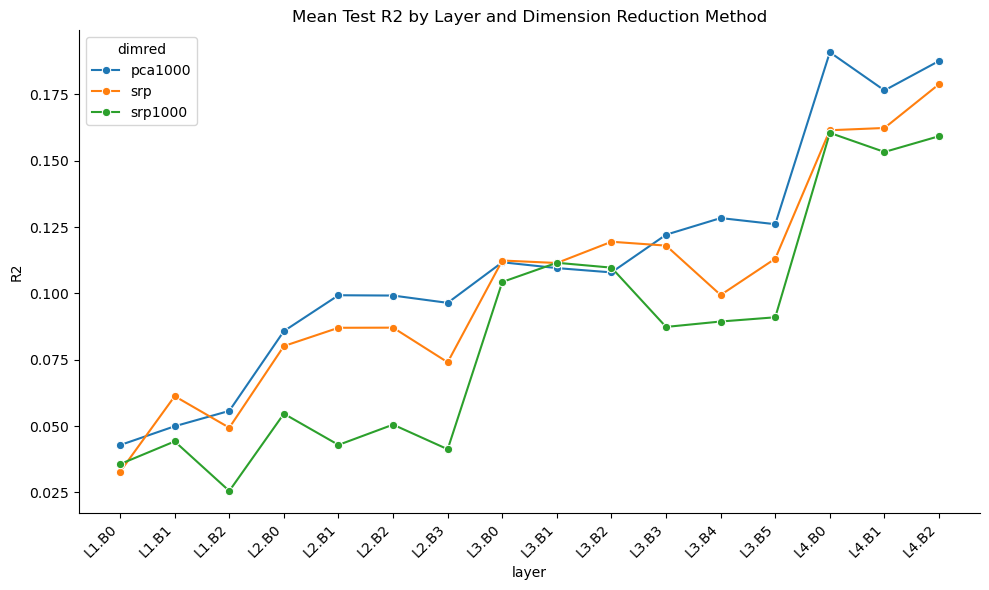

In [62]:
# Select units with reliability > 0.2 and average across those units
reliable_units = reliability > 0.5
mean_R2 = test_R2_xr.sel(unit=test_R2_xr.unit[reliable_units]).mean(dim='unit')
# Convert to dataframe for plotting
mean_R2_df = mean_R2.to_dataframe('R2').reset_index()
# Create line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_R2_df, x='layer', y='R2', hue='dimred', marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Mean Test R2 by Layer and Dimension Reduction Method')
plt.tight_layout()

In [ ]:
synopsis_xr

<xarray.Dataset> Size: 22kB
Dimensions:      (sample: 24, layer: 16, dimred: 3)
Coordinates:
  * layer        (layer) object 128B '.layer1.Bottleneck0' ... '.layer4.Bottl...
  * dimred       (dimred) object 24B 'pca1000' 'srp' 'srp1000'
    subject_id   (sample) <U23 2kB 'paul_240713-240710' ... 'baby5_240819-240...
    modelname    (sample) <U15 1kB 'resnet50_clip' ... 'resnet50_robust'
Dimensions without coordinates: sample
Data variables:
    train_score  (sample, layer, dimred) float64 9kB 0.4486 0.3978 ... 0.1146
    test_score   (sample, layer, dimred) float64 9kB 0.04813 0.04336 ... 0.02708

### Scratch

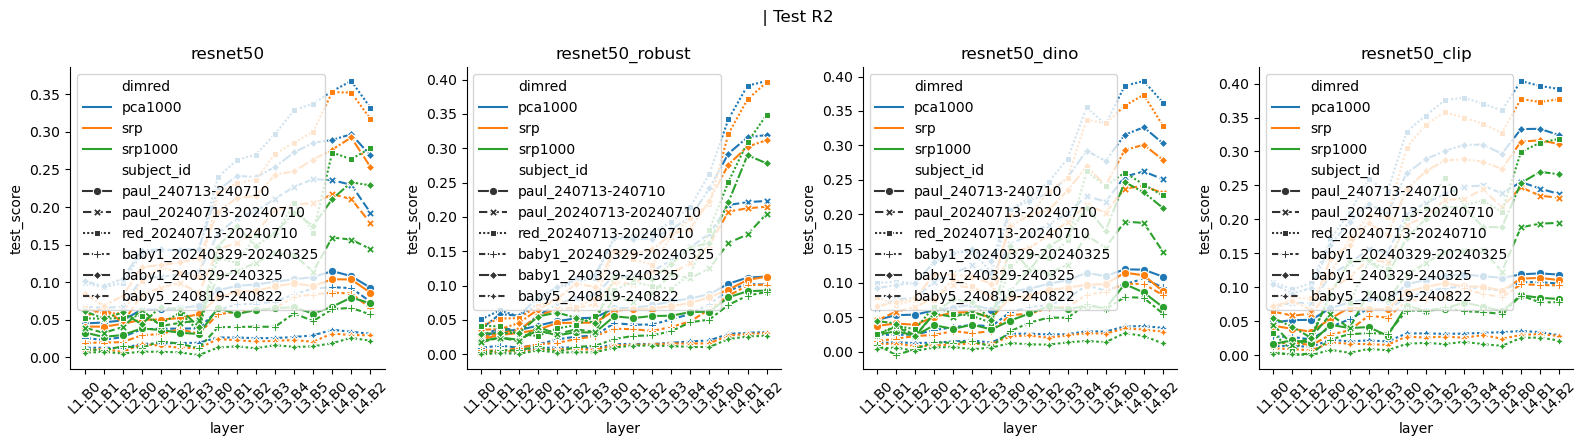

In [ ]:
shorten_func = lambda x: x.replace("Bottleneck", "B").replace(".layer", "L")
fig, axes = plt.subplots(1, 4, figsize=(16, 4.5))
axes = axes.flatten()
for i, modelname in enumerate(["resnet50", "resnet50_robust", "resnet50_dino", "resnet50_clip", ]):
    subdf = synopsis_df.query("modelname == @modelname")
    sns.lineplot(data=subdf, x="layer", y="test_score", 
                 hue="dimred",  style="subject_id", ax=axes[i], markers=True)
    axes[i].set_title(modelname)
    axes[i].tick_params(axis='x', rotation=45)
    # make the xticks be the layer names, simpler and more readable
    xticklabels = axes[i].get_xticklabels()
    xticklabels = [shorten_func(label.get_text()) for label in xticklabels]
    axes[i].set_xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    # axes[i].set_title("Training R2")

plt.suptitle(" | Test R2")
plt.tight_layout()